In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import utils
from environment import RULEnvironment

from stable_baselines3 import DQN 
from stable_baselines3.common.env_checker import check_env

### Load and preprocess train data

In [2]:
# Config
figsize = (9, 3)

In [3]:
data_path = "./data"
data = utils.load_data(data_path)
data.head()

src  machine  cycle      p1      p2     p3      s1      s2  \
0  train_FD001        1      1 -0.0007 -0.0004  100.0  518.67  641.82   
1  train_FD001        1      2  0.0019 -0.0003  100.0  518.67  642.15   
2  train_FD001        1      3 -0.0043  0.0003  100.0  518.67  642.35   
3  train_FD001        1      4  0.0007  0.0000  100.0  518.67  642.35   
4  train_FD001        1      5 -0.0019 -0.0002  100.0  518.67  642.37   

        s3       s4  ...      s13      s14     s15   s16  s17   s18    s19  \
0  1589.70  1400.60  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  1591.82  1403.14  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  1587.99  1404.20  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  1582.79  1401.87  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  1582.85  1406.22  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  rul  
0  39.06  23.4190  191  
1  39.00  23.4236  190  
2  38.95  23.3442  189  
3  38.88  23.3739  188  
4  38.90  23.4044  187  

[5 rows x 28 columns]

In [4]:
# Last column is the RUL (Label)
dt_in = list(data.columns[3:-1])
data[dt_in].describe()

p1             p2             p3             s1  \
count  160359.000000  160359.000000  160359.000000  160359.000000   
mean       17.211973       0.410004      95.724344     485.840890   
std        16.527988       0.367938      12.359044      30.420388   
min        -0.008700      -0.000600      60.000000     445.000000   
25%         0.001300       0.000200     100.000000     449.440000   
50%        19.998100       0.620000     100.000000     489.050000   
75%        35.001500       0.840000     100.000000     518.670000   
max        42.008000       0.842000     100.000000     518.670000   

                  s2             s3             s4             s5  \
count  160359.000000  160359.000000  160359.000000  160359.000000   
mean      597.361022    1467.035653    1260.956434       9.894999   
std        42.478516     118.175261     136.300073       4.265554   
min       535.480000    1242.670000    1023.770000       3.910000   
25%       549.960000    1357.360000    1126.830000       5.480000   
50%       605.930000    1492.810000    1271.740000       9.350000   
75%       642.340000    1586.590000    1402.200000      14.620000   
max       645.110000    1616.910000    1441.490000      14.620000   

                  s6             s7  ...            s12            s13  \
count  160359.000000  160359.000000  ...  160359.000000  160359.000000   
mean       14.424935     359.729968  ...     338.789821    2349.645243   
std         6.443922     174.133835  ...     164.193480     111.167242   
min         5.670000     136.170000  ...     128.310000    2027.570000   
25%         8.000000     175.710000  ...     164.790000    2387.970000   
50%        13.660000     341.690000  ...     321.690000    2388.070000   
75%        21.610000     553.290000  ...     521.340000    2388.160000   
max        21.610000     570.810000  ...     537.490000    2390.490000   

                 s14            s15            s16            s17  \
count  160359.000000  160359.000000  160359.000000  160359.000000   
mean     8088.950972       9.054747       0.025185     360.698801   
std        80.623257       0.751581       0.004997      31.021430   
min      7845.780000       8.156300       0.020000     302.000000   
25%      8070.530000       8.439250       0.020000     332.000000   
50%      8118.590000       9.030100       0.030000     367.000000   
75%      8139.410000       9.344200       0.030000     392.000000   
max      8293.720000      11.066900       0.030000     400.000000   

                 s18            s19            s20            s21  
count  160359.000000  160359.000000  160359.000000  160359.000000  
mean     2273.754039      98.389146      25.942709      15.565700  
std       142.513114       4.656270      11.691422       7.015067  
min      1915.000000      84.930000      10.160000       6.010500  
25%      2212.000000     100.000000      14.330000       8.601300  
50%      2319.000000     100.000000      24.920000      14.953500  
75%      2388.000000     100.000000      38.820000      23.294600  
max      2388.000000     100.000000      39.890000      23.950500  

[8 rows x 24 columns]

In [5]:
# Check for null-values
data[dt_in].isnull().any().any()

# No null values

False

In [6]:
# Standardize all the daa-columns
data_sv = data.copy()
data_sv[dt_in] = (data_sv[dt_in] - data_sv[dt_in].mean()) / data_sv[dt_in].std()
data_sv.head()

src  machine  cycle        p1        p2        p3        s1  \
0  train_FD001        1      1 -1.041426 -1.115415  0.345954  1.079181   
1  train_FD001        1      2 -1.041268 -1.115143  0.345954  1.079181   
2  train_FD001        1      3 -1.041644 -1.113512  0.345954  1.079181   
3  train_FD001        1      4 -1.041341 -1.114327  0.345954  1.079181   
4  train_FD001        1      5 -1.041498 -1.114871  0.345954  1.079181   

         s2        s3        s4  ...       s13       s14       s15       s16  \
0  1.046623  1.037987  1.024530  ...  0.345198  0.616063 -0.845214  0.963586   
1  1.054391  1.055926  1.043166  ...  0.345648  0.527627 -0.828849  0.963586   
2  1.059100  1.023517  1.050943  ...  0.345288  0.549209 -0.847476  0.963586   
3  1.059100  0.979514  1.033848  ...  0.345738  0.556651 -0.913470  0.963586   
4  1.059570  0.980022  1.065763  ...  0.345378  0.556279 -0.832042  0.963586   

        s17       s18       s19       s20       s21  rul  
0  1.009019  0.801652  0.345954  1.121959  1.119490  191  
1  1.009019  0.801652  0.345954  1.116827  1.120146  190  
2  0.944547  0.801652  0.345954  1.112550  1.108828  189  
3  1.009019  0.801652  0.345954  1.106563  1.113061  188  
4  1.041254  0.801652  0.345954  1.108273  1.117409  187  

[5 rows x 28 columns]

In [7]:
data_sv_dict = utils.split_by_field(data_sv, field='src')
print('{{{}}}'.format(', '.join(f'{k}: ...' for k in data_sv_dict.keys())))

{train_FD001: ..., train_FD002: ..., train_FD003: ..., train_FD004: ...}


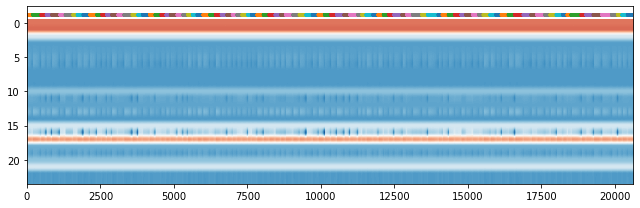

In [8]:
tmp = data_sv_dict['train_FD001']
utils.plot_dataframe(tmp[dt_in], labels=tmp['machine'], figsize=figsize)

### Train environment

In [9]:
env = RULEnvironment(data_sv, dt_in)

/Users/andreastettejessen/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [10]:
states = env.observation_space.shape
actions = env.action_space.n
states

(24,)

In [11]:
#check_env(env)

### Test environment

In [12]:
data_path = "./data"
data_test = utils.load_data(data_path, test=True)
dt_in_test = list(data_test.columns[3:-1])
data_test.describe()

# 707 machines
# Max amount of cycles: 486

machine          cycle             p1             p2  \
count  104897.000000  104897.000000  104897.000000  104897.000000   
mean      372.662478      95.406589      17.243810       0.410887   
std       201.744654      74.311486      16.530141       0.368078   
min         1.000000       1.000000      -0.008700      -0.000600   
25%       197.000000      38.000000       0.001300       0.000200   
50%       390.000000      80.000000      19.998200       0.620000   
75%       544.000000     135.000000      35.001500       0.840000   
max       707.000000     486.000000      42.008000       0.842000   

                  p3             s1             s2             s3  \
count  104897.000000  104897.000000  104897.000000  104897.000000   
mean       95.748591     485.791314     597.153354    1464.738375   
std        12.328151      30.426804      42.430629     117.856835   
min        60.000000     445.000000     535.410000    1240.940000   
25%       100.000000     449.440000     549.780000    1355.140000   
50%       100.000000     489.050000     605.530000    1490.160000   
75%       100.000000     518.670000     642.200000    1584.810000   
max       100.000000     518.670000     644.320000    1609.690000   

                  s4             s5  ...            s13            s14  \
count  104897.000000  104897.000000  ...  104897.000000  104897.000000   
mean     1257.240382       9.887805  ...    2349.811235    8084.687648   
std       135.728855       4.265536  ...     110.890533      78.956087   
min      1024.900000       3.910000  ...    2027.740000    7849.800000   
25%      1124.030000       5.480000  ...    2387.950000    8068.360000   
50%      1262.850000       9.350000  ...    2388.050000    8113.100000   
75%      1399.460000      14.620000  ...    2388.110000    8136.630000   
max      1434.120000      14.620000  ...    2389.960000    8243.100000   

                 s15            s16            s17            s18  \
count  104897.000000  104897.000000  104897.000000  104897.000000   
mean        9.046593       0.025039     360.088096    2273.841797   
std         0.748390       0.005000      30.932463     142.218102   
min         8.198000       0.020000     302.000000    1915.000000   
25%         8.425600       0.020000     331.000000    2212.000000   
50%         9.108500       0.030000     367.000000    2319.000000   
75%         9.333900       0.030000     392.000000    2388.000000   
max        11.030000       0.030000     398.000000    2388.000000   

                 s19            s20            s21            rul  
count  104897.000000  104897.000000  104897.000000  104897.000000  
mean       98.398282      25.949868      15.570426      94.406589  
std         4.644631      11.701010       7.020590      74.311486  
min        84.930000      10.180000       6.123100       0.000000  
25%       100.000000      14.340000       8.607300      37.000000  
50%       100.000000      24.780000      14.872400      79.000000  
75%       100.000000      38.880000      23.331000     134.000000  
max       100.000000      39.750000      23.849600     485.000000  

[8 rows x 27 columns]

In [13]:
# Check for null-values
data_test[dt_in_test].isnull().any().any()

# No null values

False

In [14]:
# Standardize all the daa-columns
data_sv_test = data_test.copy()
data_sv_test[dt_in_test] = (data_sv_test[dt_in_test] - data_sv_test[dt_in_test].mean()) / data_sv_test[dt_in_test].std()
data_sv_test.describe()

machine          cycle            p1            p2            p3  \
count  104897.000000  104897.000000  1.048970e+05  1.048970e+05  1.048970e+05   
mean      372.662478      95.406589 -3.528484e-14  2.732508e-13  6.284801e-14   
std       201.744654      74.311486  1.000000e+00  1.000000e+00  1.000000e+00   
min         1.000000       1.000000 -1.043700e+00 -1.117934e+00 -2.899753e+00   
25%       197.000000      38.000000 -1.043095e+00 -1.115760e+00  3.448537e-01   
50%       390.000000      80.000000  1.666284e-01  5.681230e-01  3.448537e-01   
75%       544.000000     135.000000  1.074261e+00  1.165823e+00  3.448537e-01   
max       707.000000     486.000000  1.498123e+00  1.171256e+00  3.448537e-01   

                 s1            s2            s3            s4            s5  \
count  1.048970e+05  1.048970e+05  1.048970e+05  1.048970e+05  1.048970e+05   
mean   2.248479e-13  1.892271e-13  2.131583e-13  2.235152e-13 -8.919049e-14   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.340638e+00 -1.455160e+00 -1.898900e+00 -1.711798e+00 -1.401419e+00   
25%   -1.194714e+00 -1.116490e+00 -9.299280e-01 -9.814448e-01 -1.033353e+00   
50%    1.070992e-01  1.974198e-01  2.156992e-01  4.132959e-02 -1.260814e-01   
75%    1.080583e+00  1.061654e+00  1.018792e+00  1.047822e+00  1.109402e+00   
max    1.080583e+00  1.111618e+00  1.229896e+00  1.303184e+00  1.109402e+00   

       ...           s13           s14           s15           s16  \
count  ...  1.048970e+05  1.048970e+05  1.048970e+05  1.048970e+05   
mean   ... -1.056916e-12 -8.490742e-13 -4.943506e-14  1.125625e-12   
std    ...  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min    ... -2.904407e+00 -2.974915e+00 -1.133891e+00 -1.007737e+00   
25%    ...  3.439317e-01 -2.067940e-01 -8.297717e-01 -1.007737e+00   
50%    ...  3.448334e-01  3.598500e-01  8.272022e-02  9.923125e-01   
75%    ...  3.453745e-01  6.578638e-01  3.839000e-01  9.923125e-01   
max    ...  3.620576e-01  2.006335e+00  2.650231e+00  9.923125e-01   

                s17           s18           s19           s20           s21  \
count  1.048970e+05  1.048970e+05  1.048970e+05  1.048970e+05  1.048970e+05   
mean   5.621568e-15 -2.647621e-14  3.206756e-12 -3.476028e-14 -3.679688e-14   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.877901e+00 -2.523179e+00 -2.899753e+00 -1.347736e+00 -1.345660e+00   
25%   -9.403744e-01 -4.348377e-01  3.448537e-01 -9.922108e-01 -9.918149e-01   
50%    2.234515e-01  3.175278e-01  3.448537e-01 -9.998010e-02 -9.942553e-02   
75%    1.031664e+00  8.026981e-01  3.448537e-01  1.105044e+00  1.105402e+00   
max    1.225635e+00  8.026981e-01  3.448537e-01  1.179397e+00  1.179270e+00   

                 rul  
count  104897.000000  
mean       94.406589  
std        74.311486  
min         0.000000  
25%        37.000000  
50%        79.000000  
75%       134.000000  
max       485.000000  

[8 rows x 27 columns]

In [15]:
env_test = RULEnvironment(data_sv_test, dt_in_test)

/Users/andreastettejessen/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [16]:
nb_episodes = data_sv_test['machine'].max()

### Evaluation of model before and after training

In [17]:
def evaluate(model, environment, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = environment
    all_episode_rewards = []
    all_nr_of_actions = []
    for i in range(num_episodes):
        episode_rewards = []
        nr_of_actions = 0
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)
            nr_of_actions += 1
        
        all_episode_rewards.append(sum(episode_rewards))
        all_nr_of_actions.append(nr_of_actions)
    plt.plot(all_episode_rewards)
    plt.plot(all_nr_of_actions)

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

In [18]:
model = DQN("MlpPolicy", env, verbose = 1, tensorboard_log="./tensorboard/")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Mean reward: -230.43333333333334 Num episodes: 600


-230.43333333333334

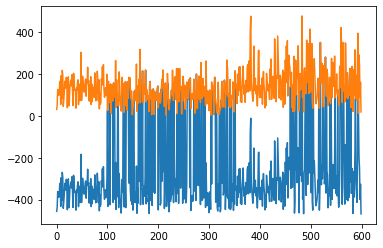

In [19]:
evaluate(model, env_test, 600)

In [20]:
model.learn(total_timesteps=300000)


Logging to ./tensorboard/1_run_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.75     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 172      |
|    time_elapsed     | 0        |
|    total_timesteps  | 7        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 8        |
|    fps              | 177      |
|    time_elapsed     | 0        |
|    total_timesteps  | 15       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.999    |
| time/               

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 92       |
|    fps              | 252      |
|    time_elapsed     | 0        |
|    total_timesteps  | 167      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes         | 96       |
|    fps              | 255      |
|    time_elapsed     | 0        |
|    total_timesteps  | 175      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.994    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 180      |
|    fps              | 283      |
|    time_elapsed     | 1        |
|    total_timesteps  | 328      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 184      |
|    fps              | 285      |
|    time_elapsed     | 1        |
|    total_timesteps  | 336      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.985    |
| time/               |          |
|    episodes         | 268      |
|    fps              | 291      |
|    time_elapsed     | 1        |
|    total_timesteps  | 489      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 272      |
|    fps              | 295      |
|    time_elapsed     | 1        |
|    total_timesteps  | 505      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.978    |
| time/               |          |
|    episodes         | 356      |
|    fps              | 313      |
|    time_elapsed     | 2        |
|    total_timesteps  | 692      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.22     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.978    |
| time/               |          |
|    episodes         | 360      |
|    fps              | 313      |
|    time_elapsed     | 2        |
|    total_timesteps  | 698      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.978    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 444      |
|    fps              | 316      |
|    time_elapsed     | 2        |
|    total_timesteps  | 860      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 448      |
|    fps              | 315      |
|    time_elapsed     | 2        |
|    total_timesteps  | 867      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.972    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes         | 532      |
|    fps              | 284      |
|    time_elapsed     | 3        |
|    total_timesteps  | 1032     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes         | 536      |
|    fps              | 283      |
|    time_elapsed     | 3        |
|    total_timesteps  | 1038     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.967    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 620      |
|    fps              | 268      |
|    time_elapsed     | 4        |
|    total_timesteps  | 1188     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 624      |
|    fps              | 264      |
|    time_elapsed     | 4        |
|    total_timesteps  | 1196     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.957    |
| time/               |          |
|    episodes         | 708      |
|    fps              | 243      |
|    time_elapsed     | 5        |
|    total_timesteps  | 1369     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.956    |
| time/               |          |
|    episodes         | 712      |
|    fps              | 243      |
|    time_elapsed     | 5        |
|    total_timesteps  | 1377     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.956    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.951    |
| time/               |          |
|    episodes         | 796      |
|    fps              | 236      |
|    time_elapsed     | 6        |
|    total_timesteps  | 1538     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.951    |
| time/               |          |
|    episodes         | 800      |
|    fps              | 237      |
|    time_elapsed     | 6        |
|    total_timesteps  | 1549     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.951    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.946    |
| time/               |          |
|    episodes         | 884      |
|    fps              | 228      |
|    time_elapsed     | 7        |
|    total_timesteps  | 1698     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.946    |
| time/               |          |
|    episodes         | 888      |
|    fps              | 226      |
|    time_elapsed     | 7        |
|    total_timesteps  | 1702     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.946    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.62     |
|    ep_rew_mean      | 1.62     |
|    exploration_rate | 0.942    |
| time/               |          |
|    episodes         | 972      |
|    fps              | 214      |
|    time_elapsed     | 8        |
|    total_timesteps  | 1844     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.66     |
|    ep_rew_mean      | 1.66     |
|    exploration_rate | 0.941    |
| time/               |          |
|    episodes         | 976      |
|    fps              | 212      |
|    time_elapsed     | 8        |
|    total_timesteps  | 1852     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.71     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.941    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.937    |
| time/               |          |
|    episodes         | 1060     |
|    fps              | 194      |
|    time_elapsed     | 10       |
|    total_timesteps  | 2004     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.936    |
| time/               |          |
|    episodes         | 1064     |
|    fps              | 194      |
|    time_elapsed     | 10       |
|    total_timesteps  | 2012     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.936    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.931    |
| time/               |          |
|    episodes         | 1148     |
|    fps              | 186      |
|    time_elapsed     | 11       |
|    total_timesteps  | 2168     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.931    |
| time/               |          |
|    episodes         | 1152     |
|    fps              | 186      |
|    time_elapsed     | 11       |
|    total_timesteps  | 2176     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.931    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.926    |
| time/               |          |
|    episodes         | 1236     |
|    fps              | 192      |
|    time_elapsed     | 12       |
|    total_timesteps  | 2343     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.925    |
| time/               |          |
|    episodes         | 1240     |
|    fps              | 192      |
|    time_elapsed     | 12       |
|    total_timesteps  | 2353     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.925    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.92     |
| time/               |          |
|    episodes         | 1324     |
|    fps              | 197      |
|    time_elapsed     | 12       |
|    total_timesteps  | 2512     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.92     |
| time/               |          |
|    episodes         | 1328     |
|    fps              | 198      |
|    time_elapsed     | 12       |
|    total_timesteps  | 2527     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.92     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.915    |
| time/               |          |
|    episodes         | 1412     |
|    fps              | 203      |
|    time_elapsed     | 13       |
|    total_timesteps  | 2691     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.915    |
| time/               |          |
|    episodes         | 1416     |
|    fps              | 203      |
|    time_elapsed     | 13       |
|    total_timesteps  | 2698     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.914    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.909    |
| time/               |          |
|    episodes         | 1500     |
|    fps              | 206      |
|    time_elapsed     | 13       |
|    total_timesteps  | 2871     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.909    |
| time/               |          |
|    episodes         | 1504     |
|    fps              | 205      |
|    time_elapsed     | 13       |
|    total_timesteps  | 2878     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.909    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.904    |
| time/               |          |
|    episodes         | 1588     |
|    fps              | 207      |
|    time_elapsed     | 14       |
|    total_timesteps  | 3042     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.903    |
| time/               |          |
|    episodes         | 1592     |
|    fps              | 206      |
|    time_elapsed     | 14       |
|    total_timesteps  | 3049     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.903    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.898    |
| time/               |          |
|    episodes         | 1676     |
|    fps              | 206      |
|    time_elapsed     | 15       |
|    total_timesteps  | 3220     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.898    |
| time/               |          |
|    episodes         | 1680     |
|    fps              | 206      |
|    time_elapsed     | 15       |
|    total_timesteps  | 3230     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.897    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.892    |
| time/               |          |
|    episodes         | 1764     |
|    fps              | 206      |
|    time_elapsed     | 16       |
|    total_timesteps  | 3405     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.892    |
| time/               |          |
|    episodes         | 1768     |
|    fps              | 206      |
|    time_elapsed     | 16       |
|    total_timesteps  | 3410     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.892    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.887    |
| time/               |          |
|    episodes         | 1852     |
|    fps              | 210      |
|    time_elapsed     | 16       |
|    total_timesteps  | 3573     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.886    |
| time/               |          |
|    episodes         | 1856     |
|    fps              | 211      |
|    time_elapsed     | 17       |
|    total_timesteps  | 3590     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.886    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.22     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.88     |
| time/               |          |
|    episodes         | 1940     |
|    fps              | 214      |
|    time_elapsed     | 17       |
|    total_timesteps  | 3774     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.88     |
| time/               |          |
|    episodes         | 1944     |
|    fps              | 214      |
|    time_elapsed     | 17       |
|    total_timesteps  | 3781     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.22     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.88     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.875    |
| time/               |          |
|    episodes         | 2028     |
|    fps              | 214      |
|    time_elapsed     | 18       |
|    total_timesteps  | 3934     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.875    |
| time/               |          |
|    episodes         | 2032     |
|    fps              | 214      |
|    time_elapsed     | 18       |
|    total_timesteps  | 3941     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.875    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.87     |
| time/               |          |
|    episodes         | 2116     |
|    fps              | 217      |
|    time_elapsed     | 18       |
|    total_timesteps  | 4118     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.869    |
| time/               |          |
|    episodes         | 2120     |
|    fps              | 217      |
|    time_elapsed     | 18       |
|    total_timesteps  | 4124     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.869    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.864    |
| time/               |          |
|    episodes         | 2204     |
|    fps              | 217      |
|    time_elapsed     | 19       |
|    total_timesteps  | 4287     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.864    |
| time/               |          |
|    episodes         | 2208     |
|    fps              | 217      |
|    time_elapsed     | 19       |
|    total_timesteps  | 4297     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.864    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.858    |
| time/               |          |
|    episodes         | 2292     |
|    fps              | 218      |
|    time_elapsed     | 20       |
|    total_timesteps  | 4484     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.22     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.858    |
| time/               |          |
|    episodes         | 2296     |
|    fps              | 218      |
|    time_elapsed     | 20       |
|    total_timesteps  | 4490     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.858    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.22     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.852    |
| time/               |          |
|    episodes         | 2380     |
|    fps              | 221      |
|    time_elapsed     | 21       |
|    total_timesteps  | 4676     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.852    |
| time/               |          |
|    episodes         | 2384     |
|    fps              | 221      |
|    time_elapsed     | 21       |
|    total_timesteps  | 4683     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.851    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.846    |
| time/               |          |
|    episodes         | 2468     |
|    fps              | 222      |
|    time_elapsed     | 21       |
|    total_timesteps  | 4852     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.846    |
| time/               |          |
|    episodes         | 2472     |
|    fps              | 222      |
|    time_elapsed     | 21       |
|    total_timesteps  | 4859     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.846    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.841    |
| time/               |          |
|    episodes         | 2556     |
|    fps              | 225      |
|    time_elapsed     | 22       |
|    total_timesteps  | 5027     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.841    |
| time/               |          |
|    episodes         | 2560     |
|    fps              | 225      |
|    time_elapsed     | 22       |
|    total_timesteps  | 5032     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.84     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.836    |
| time/               |          |
|    episodes         | 2644     |
|    fps              | 225      |
|    time_elapsed     | 22       |
|    total_timesteps  | 5194     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.835    |
| time/               |          |
|    episodes         | 2648     |
|    fps              | 225      |
|    time_elapsed     | 23       |
|    total_timesteps  | 5203     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.835    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.83     |
| time/               |          |
|    episodes         | 2732     |
|    fps              | 226      |
|    time_elapsed     | 23       |
|    total_timesteps  | 5361     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.83     |
| time/               |          |
|    episodes         | 2736     |
|    fps              | 227      |
|    time_elapsed     | 23       |
|    total_timesteps  | 5370     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.83     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.825    |
| time/               |          |
|    episodes         | 2820     |
|    fps              | 229      |
|    time_elapsed     | 24       |
|    total_timesteps  | 5540     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.824    |
| time/               |          |
|    episodes         | 2824     |
|    fps              | 229      |
|    time_elapsed     | 24       |
|    total_timesteps  | 5547     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.824    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.819    |
| time/               |          |
|    episodes         | 2908     |
|    fps              | 230      |
|    time_elapsed     | 24       |
|    total_timesteps  | 5711     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.819    |
| time/               |          |
|    episodes         | 2912     |
|    fps              | 231      |
|    time_elapsed     | 24       |
|    total_timesteps  | 5724     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.818    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.813    |
| time/               |          |
|    episodes         | 2996     |
|    fps              | 232      |
|    time_elapsed     | 25       |
|    total_timesteps  | 5896     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.813    |
| time/               |          |
|    episodes         | 3000     |
|    fps              | 232      |
|    time_elapsed     | 25       |
|    total_timesteps  | 5905     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.813    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.808    |
| time/               |          |
|    episodes         | 3084     |
|    fps              | 234      |
|    time_elapsed     | 25       |
|    total_timesteps  | 6066     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.808    |
| time/               |          |
|    episodes         | 3088     |
|    fps              | 234      |
|    time_elapsed     | 25       |
|    total_timesteps  | 6073     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.807    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.802    |
| time/               |          |
|    episodes         | 3172     |
|    fps              | 236      |
|    time_elapsed     | 26       |
|    total_timesteps  | 6240     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.802    |
| time/               |          |
|    episodes         | 3176     |
|    fps              | 236      |
|    time_elapsed     | 26       |
|    total_timesteps  | 6247     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.802    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.797    |
| time/               |          |
|    episodes         | 3260     |
|    fps              | 236      |
|    time_elapsed     | 27       |
|    total_timesteps  | 6397     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.797    |
| time/               |          |
|    episodes         | 3264     |
|    fps              | 236      |
|    time_elapsed     | 27       |
|    total_timesteps  | 6407     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.797    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.792    |
| time/               |          |
|    episodes         | 3348     |
|    fps              | 235      |
|    time_elapsed     | 27       |
|    total_timesteps  | 6566     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.792    |
| time/               |          |
|    episodes         | 3352     |
|    fps              | 235      |
|    time_elapsed     | 27       |
|    total_timesteps  | 6574     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.791    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.786    |
| time/               |          |
|    episodes         | 3436     |
|    fps              | 236      |
|    time_elapsed     | 28       |
|    total_timesteps  | 6745     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.786    |
| time/               |          |
|    episodes         | 3440     |
|    fps              | 236      |
|    time_elapsed     | 28       |
|    total_timesteps  | 6750     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.786    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.781    |
| time/               |          |
|    episodes         | 3524     |
|    fps              | 237      |
|    time_elapsed     | 29       |
|    total_timesteps  | 6929     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.78     |
| time/               |          |
|    episodes         | 3528     |
|    fps              | 237      |
|    time_elapsed     | 29       |
|    total_timesteps  | 6934     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.78     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.775    |
| time/               |          |
|    episodes         | 3612     |
|    fps              | 236      |
|    time_elapsed     | 30       |
|    total_timesteps  | 7111     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.775    |
| time/               |          |
|    episodes         | 3616     |
|    fps              | 236      |
|    time_elapsed     | 30       |
|    total_timesteps  | 7119     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.774    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.77     |
| time/               |          |
|    episodes         | 3700     |
|    fps              | 237      |
|    time_elapsed     | 30       |
|    total_timesteps  | 7265     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.77     |
| time/               |          |
|    episodes         | 3704     |
|    fps              | 237      |
|    time_elapsed     | 30       |
|    total_timesteps  | 7271     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.769    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.764    |
| time/               |          |
|    episodes         | 3788     |
|    fps              | 238      |
|    time_elapsed     | 31       |
|    total_timesteps  | 7439     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.764    |
| time/               |          |
|    episodes         | 3792     |
|    fps              | 238      |
|    time_elapsed     | 31       |
|    total_timesteps  | 7443     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.764    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.759    |
| time/               |          |
|    episodes         | 3876     |
|    fps              | 239      |
|    time_elapsed     | 31       |
|    total_timesteps  | 7601     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.759    |
| time/               |          |
|    episodes         | 3880     |
|    fps              | 239      |
|    time_elapsed     | 31       |
|    total_timesteps  | 7608     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.759    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.754    |
| time/               |          |
|    episodes         | 3964     |
|    fps              | 240      |
|    time_elapsed     | 32       |
|    total_timesteps  | 7760     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.754    |
| time/               |          |
|    episodes         | 3968     |
|    fps              | 240      |
|    time_elapsed     | 32       |
|    total_timesteps  | 7770     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.754    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.749    |
| time/               |          |
|    episodes         | 4052     |
|    fps              | 241      |
|    time_elapsed     | 32       |
|    total_timesteps  | 7936     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.748    |
| time/               |          |
|    episodes         | 4056     |
|    fps              | 241      |
|    time_elapsed     | 32       |
|    total_timesteps  | 7945     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.748    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.743    |
| time/               |          |
|    episodes         | 4140     |
|    fps              | 243      |
|    time_elapsed     | 33       |
|    total_timesteps  | 8112     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.743    |
| time/               |          |
|    episodes         | 4144     |
|    fps              | 243      |
|    time_elapsed     | 33       |
|    total_timesteps  | 8122     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.743    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.738    |
| time/               |          |
|    episodes         | 4228     |
|    fps              | 244      |
|    time_elapsed     | 33       |
|    total_timesteps  | 8289     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.737    |
| time/               |          |
|    episodes         | 4232     |
|    fps              | 244      |
|    time_elapsed     | 33       |
|    total_timesteps  | 8295     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.737    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.732    |
| time/               |          |
|    episodes         | 4316     |
|    fps              | 244      |
|    time_elapsed     | 34       |
|    total_timesteps  | 8455     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.732    |
| time/               |          |
|    episodes         | 4320     |
|    fps              | 244      |
|    time_elapsed     | 34       |
|    total_timesteps  | 8460     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.732    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.727    |
| time/               |          |
|    episodes         | 4404     |
|    fps              | 239      |
|    time_elapsed     | 35       |
|    total_timesteps  | 8622     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.727    |
| time/               |          |
|    episodes         | 4408     |
|    fps              | 239      |
|    time_elapsed     | 36       |
|    total_timesteps  | 8632     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.726    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.721    |
| time/               |          |
|    episodes         | 4492     |
|    fps              | 239      |
|    time_elapsed     | 36       |
|    total_timesteps  | 8801     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.721    |
| time/               |          |
|    episodes         | 4496     |
|    fps              | 239      |
|    time_elapsed     | 36       |
|    total_timesteps  | 8805     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.721    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.716    |
| time/               |          |
|    episodes         | 4580     |
|    fps              | 241      |
|    time_elapsed     | 37       |
|    total_timesteps  | 8973     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.716    |
| time/               |          |
|    episodes         | 4584     |
|    fps              | 241      |
|    time_elapsed     | 37       |
|    total_timesteps  | 8979     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.715    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.71     |
| time/               |          |
|    episodes         | 4668     |
|    fps              | 242      |
|    time_elapsed     | 37       |
|    total_timesteps  | 9150     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.71     |
| time/               |          |
|    episodes         | 4672     |
|    fps              | 242      |
|    time_elapsed     | 37       |
|    total_timesteps  | 9156     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.71     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.705    |
| time/               |          |
|    episodes         | 4756     |
|    fps              | 243      |
|    time_elapsed     | 38       |
|    total_timesteps  | 9318     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.705    |
| time/               |          |
|    episodes         | 4760     |
|    fps              | 243      |
|    time_elapsed     | 38       |
|    total_timesteps  | 9325     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.704    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.699    |
| time/               |          |
|    episodes         | 4844     |
|    fps              | 244      |
|    time_elapsed     | 38       |
|    total_timesteps  | 9509     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.698    |
| time/               |          |
|    episodes         | 4848     |
|    fps              | 245      |
|    time_elapsed     | 38       |
|    total_timesteps  | 9522     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.698    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.693    |
| time/               |          |
|    episodes         | 4932     |
|    fps              | 245      |
|    time_elapsed     | 39       |
|    total_timesteps  | 9685     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.693    |
| time/               |          |
|    episodes         | 4936     |
|    fps              | 245      |
|    time_elapsed     | 39       |
|    total_timesteps  | 9694     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.693    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.687    |
| time/               |          |
|    episodes         | 5020     |
|    fps              | 245      |
|    time_elapsed     | 40       |
|    total_timesteps  | 9871     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.687    |
| time/               |          |
|    episodes         | 5024     |
|    fps              | 245      |
|    time_elapsed     | 40       |
|    total_timesteps  | 9882     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.18     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.687    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.682    |
| time/               |          |
|    episodes         | 5108     |
|    fps              | 246      |
|    time_elapsed     | 40       |
|    total_timesteps  | 10045    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.682    |
| time/               |          |
|    episodes         | 5112     |
|    fps              | 246      |
|    time_elapsed     | 40       |
|    total_timesteps  | 10052    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.681    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.677    |
| time/               |          |
|    episodes         | 5196     |
|    fps              | 242      |
|    time_elapsed     | 42       |
|    total_timesteps  | 10212    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.676    |
| time/               |          |
|    episodes         | 5200     |
|    fps              | 242      |
|    time_elapsed     | 42       |
|    total_timesteps  | 10220    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.676    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.671    |
| time/               |          |
|    episodes         | 5284     |
|    fps              | 241      |
|    time_elapsed     | 42       |
|    total_timesteps  | 10397    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.671    |
| time/               |          |
|    episodes         | 5288     |
|    fps              | 241      |
|    time_elapsed     | 43       |
|    total_timesteps  | 10405    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.67     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.666    |
| time/               |          |
|    episodes         | 5372     |
|    fps              | 240      |
|    time_elapsed     | 43       |
|    total_timesteps  | 10561    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.665    |
| time/               |          |
|    episodes         | 5376     |
|    fps              | 240      |
|    time_elapsed     | 43       |
|    total_timesteps  | 10567    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.665    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.73     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.661    |
| time/               |          |
|    episodes         | 5460     |
|    fps              | 237      |
|    time_elapsed     | 45       |
|    total_timesteps  | 10717    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.66     |
| time/               |          |
|    episodes         | 5464     |
|    fps              | 237      |
|    time_elapsed     | 45       |
|    total_timesteps  | 10731    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.66     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.655    |
| time/               |          |
|    episodes         | 5548     |
|    fps              | 238      |
|    time_elapsed     | 45       |
|    total_timesteps  | 10885    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.655    |
| time/               |          |
|    episodes         | 5552     |
|    fps              | 238      |
|    time_elapsed     | 45       |
|    total_timesteps  | 10890    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.655    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.65     |
| time/               |          |
|    episodes         | 5636     |
|    fps              | 239      |
|    time_elapsed     | 46       |
|    total_timesteps  | 11064    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.649    |
| time/               |          |
|    episodes         | 5640     |
|    fps              | 239      |
|    time_elapsed     | 46       |
|    total_timesteps  | 11072    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.649    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.644    |
| time/               |          |
|    episodes         | 5724     |
|    fps              | 241      |
|    time_elapsed     | 46       |
|    total_timesteps  | 11253    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.643    |
| time/               |          |
|    episodes         | 5728     |
|    fps              | 241      |
|    time_elapsed     | 46       |
|    total_timesteps  | 11262    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.643    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.638    |
| time/               |          |
|    episodes         | 5812     |
|    fps              | 242      |
|    time_elapsed     | 47       |
|    total_timesteps  | 11421    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.638    |
| time/               |          |
|    episodes         | 5816     |
|    fps              | 242      |
|    time_elapsed     | 47       |
|    total_timesteps  | 11429    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.638    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.633    |
| time/               |          |
|    episodes         | 5900     |
|    fps              | 243      |
|    time_elapsed     | 47       |
|    total_timesteps  | 11599    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.633    |
| time/               |          |
|    episodes         | 5904     |
|    fps              | 243      |
|    time_elapsed     | 47       |
|    total_timesteps  | 11605    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.632    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.626    |
| time/               |          |
|    episodes         | 5988     |
|    fps              | 244      |
|    time_elapsed     | 48       |
|    total_timesteps  | 11795    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.626    |
| time/               |          |
|    episodes         | 5992     |
|    fps              | 244      |
|    time_elapsed     | 48       |
|    total_timesteps  | 11801    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.626    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.621    |
| time/               |          |
|    episodes         | 6076     |
|    fps              | 245      |
|    time_elapsed     | 48       |
|    total_timesteps  | 11963    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.621    |
| time/               |          |
|    episodes         | 6080     |
|    fps              | 245      |
|    time_elapsed     | 48       |
|    total_timesteps  | 11969    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.621    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.616    |
| time/               |          |
|    episodes         | 6164     |
|    fps              | 246      |
|    time_elapsed     | 49       |
|    total_timesteps  | 12140    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.615    |
| time/               |          |
|    episodes         | 6168     |
|    fps              | 246      |
|    time_elapsed     | 49       |
|    total_timesteps  | 12146    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.615    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.61     |
| time/               |          |
|    episodes         | 6252     |
|    fps              | 247      |
|    time_elapsed     | 49       |
|    total_timesteps  | 12308    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.61     |
| time/               |          |
|    episodes         | 6256     |
|    fps              | 247      |
|    time_elapsed     | 49       |
|    total_timesteps  | 12317    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.61     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.68     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.606    |
| time/               |          |
|    episodes         | 6340     |
|    fps              | 247      |
|    time_elapsed     | 50       |
|    total_timesteps  | 12453    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.68     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.605    |
| time/               |          |
|    episodes         | 6344     |
|    fps              | 247      |
|    time_elapsed     | 50       |
|    total_timesteps  | 12458    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.67     |
|    ep_rew_mean      | 1.67     |
|    exploration_rate | 0.605    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 6428     |
|    fps              | 248      |
|    time_elapsed     | 50       |
|    total_timesteps  | 12632    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.6      |
| time/               |          |
|    episodes         | 6432     |
|    fps              | 249      |
|    time_elapsed     | 50       |
|    total_timesteps  | 12640    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.599    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.595    |
| time/               |          |
|    episodes         | 6516     |
|    fps              | 249      |
|    time_elapsed     | 51       |
|    total_timesteps  | 12787    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.595    |
| time/               |          |
|    episodes         | 6520     |
|    fps              | 249      |
|    time_elapsed     | 51       |
|    total_timesteps  | 12793    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.77     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.595    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.72     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.59     |
| time/               |          |
|    episodes         | 6604     |
|    fps              | 250      |
|    time_elapsed     | 51       |
|    total_timesteps  | 12941    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.59     |
| time/               |          |
|    episodes         | 6608     |
|    fps              | 250      |
|    time_elapsed     | 51       |
|    total_timesteps  | 12956    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.59     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.584    |
| time/               |          |
|    episodes         | 6692     |
|    fps              | 251      |
|    time_elapsed     | 52       |
|    total_timesteps  | 13123    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.584    |
| time/               |          |
|    episodes         | 6696     |
|    fps              | 251      |
|    time_elapsed     | 52       |
|    total_timesteps  | 13132    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.584    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.579    |
| time/               |          |
|    episodes         | 6780     |
|    fps              | 251      |
|    time_elapsed     | 52       |
|    total_timesteps  | 13295    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.579    |
| time/               |          |
|    episodes         | 6784     |
|    fps              | 252      |
|    time_elapsed     | 52       |
|    total_timesteps  | 13305    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.578    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.573    |
| time/               |          |
|    episodes         | 6868     |
|    fps              | 249      |
|    time_elapsed     | 54       |
|    total_timesteps  | 13480    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.573    |
| time/               |          |
|    episodes         | 6872     |
|    fps              | 249      |
|    time_elapsed     | 54       |
|    total_timesteps  | 13487    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.573    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.567    |
| time/               |          |
|    episodes         | 6956     |
|    fps              | 248      |
|    time_elapsed     | 54       |
|    total_timesteps  | 13663    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.567    |
| time/               |          |
|    episodes         | 6960     |
|    fps              | 248      |
|    time_elapsed     | 54       |
|    total_timesteps  | 13672    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.567    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.562    |
| time/               |          |
|    episodes         | 7044     |
|    fps              | 249      |
|    time_elapsed     | 55       |
|    total_timesteps  | 13844    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.561    |
| time/               |          |
|    episodes         | 7048     |
|    fps              | 249      |
|    time_elapsed     | 55       |
|    total_timesteps  | 13853    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.561    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.556    |
| time/               |          |
|    episodes         | 7132     |
|    fps              | 248      |
|    time_elapsed     | 56       |
|    total_timesteps  | 14013    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.556    |
| time/               |          |
|    episodes         | 7136     |
|    fps              | 248      |
|    time_elapsed     | 56       |
|    total_timesteps  | 14021    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.556    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.551    |
| time/               |          |
|    episodes         | 7220     |
|    fps              | 246      |
|    time_elapsed     | 57       |
|    total_timesteps  | 14177    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.551    |
| time/               |          |
|    episodes         | 7224     |
|    fps              | 246      |
|    time_elapsed     | 57       |
|    total_timesteps  | 14182    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.551    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.545    |
| time/               |          |
|    episodes         | 7308     |
|    fps              | 247      |
|    time_elapsed     | 58       |
|    total_timesteps  | 14373    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.545    |
| time/               |          |
|    episodes         | 7312     |
|    fps              | 247      |
|    time_elapsed     | 58       |
|    total_timesteps  | 14381    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.544    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.54     |
| time/               |          |
|    episodes         | 7396     |
|    fps              | 247      |
|    time_elapsed     | 58       |
|    total_timesteps  | 14539    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.539    |
| time/               |          |
|    episodes         | 7400     |
|    fps              | 247      |
|    time_elapsed     | 58       |
|    total_timesteps  | 14545    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.539    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.29     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.533    |
| time/               |          |
|    episodes         | 7484     |
|    fps              | 247      |
|    time_elapsed     | 59       |
|    total_timesteps  | 14747    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.28     |
|    ep_rew_mean      | 2.28     |
|    exploration_rate | 0.533    |
| time/               |          |
|    episodes         | 7488     |
|    fps              | 247      |
|    time_elapsed     | 59       |
|    total_timesteps  | 14751    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.3      |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.533    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.528    |
| time/               |          |
|    episodes         | 7572     |
|    fps              | 248      |
|    time_elapsed     | 59       |
|    total_timesteps  | 14909    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.528    |
| time/               |          |
|    episodes         | 7576     |
|    fps              | 248      |
|    time_elapsed     | 60       |
|    total_timesteps  | 14914    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.527    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.522    |
| time/               |          |
|    episodes         | 7660     |
|    fps              | 248      |
|    time_elapsed     | 60       |
|    total_timesteps  | 15079    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.522    |
| time/               |          |
|    episodes         | 7664     |
|    fps              | 248      |
|    time_elapsed     | 60       |
|    total_timesteps  | 15089    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.522    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.517    |
| time/               |          |
|    episodes         | 7748     |
|    fps              | 247      |
|    time_elapsed     | 61       |
|    total_timesteps  | 15250    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.517    |
| time/               |          |
|    episodes         | 7752     |
|    fps              | 247      |
|    time_elapsed     | 61       |
|    total_timesteps  | 15256    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.517    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.512    |
| time/               |          |
|    episodes         | 7836     |
|    fps              | 247      |
|    time_elapsed     | 62       |
|    total_timesteps  | 15405    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.75     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.512    |
| time/               |          |
|    episodes         | 7840     |
|    fps              | 247      |
|    time_elapsed     | 62       |
|    total_timesteps  | 15410    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.75     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.512    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.506    |
| time/               |          |
|    episodes         | 7924     |
|    fps              | 247      |
|    time_elapsed     | 62       |
|    total_timesteps  | 15587    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.506    |
| time/               |          |
|    episodes         | 7928     |
|    fps              | 247      |
|    time_elapsed     | 63       |
|    total_timesteps  | 15595    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.506    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.72     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.502    |
| time/               |          |
|    episodes         | 8012     |
|    fps              | 247      |
|    time_elapsed     | 63       |
|    total_timesteps  | 15734    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.7      |
|    ep_rew_mean      | 1.7      |
|    exploration_rate | 0.502    |
| time/               |          |
|    episodes         | 8016     |
|    fps              | 247      |
|    time_elapsed     | 63       |
|    total_timesteps  | 15738    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.69     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.501    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.497    |
| time/               |          |
|    episodes         | 8100     |
|    fps              | 247      |
|    time_elapsed     | 64       |
|    total_timesteps  | 15896    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.496    |
| time/               |          |
|    episodes         | 8104     |
|    fps              | 247      |
|    time_elapsed     | 64       |
|    total_timesteps  | 15902    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.496    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.492    |
| time/               |          |
|    episodes         | 8188     |
|    fps              | 247      |
|    time_elapsed     | 64       |
|    total_timesteps  | 16056    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.77     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.491    |
| time/               |          |
|    episodes         | 8192     |
|    fps              | 247      |
|    time_elapsed     | 64       |
|    total_timesteps  | 16061    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.491    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.486    |
| time/               |          |
|    episodes         | 8276     |
|    fps              | 248      |
|    time_elapsed     | 65       |
|    total_timesteps  | 16226    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.486    |
| time/               |          |
|    episodes         | 8280     |
|    fps              | 248      |
|    time_elapsed     | 65       |
|    total_timesteps  | 16236    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.486    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.48     |
| time/               |          |
|    episodes         | 8364     |
|    fps              | 248      |
|    time_elapsed     | 65       |
|    total_timesteps  | 16407    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.48     |
| time/               |          |
|    episodes         | 8368     |
|    fps              | 248      |
|    time_elapsed     | 65       |
|    total_timesteps  | 16413    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.48     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.475    |
| time/               |          |
|    episodes         | 8452     |
|    fps              | 248      |
|    time_elapsed     | 66       |
|    total_timesteps  | 16570    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.475    |
| time/               |          |
|    episodes         | 8456     |
|    fps              | 248      |
|    time_elapsed     | 66       |
|    total_timesteps  | 16576    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.475    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.469    |
| time/               |          |
|    episodes         | 8540     |
|    fps              | 249      |
|    time_elapsed     | 67       |
|    total_timesteps  | 16756    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.469    |
| time/               |          |
|    episodes         | 8544     |
|    fps              | 249      |
|    time_elapsed     | 67       |
|    total_timesteps  | 16761    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.469    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.464    |
| time/               |          |
|    episodes         | 8628     |
|    fps              | 248      |
|    time_elapsed     | 68       |
|    total_timesteps  | 16941    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.463    |
| time/               |          |
|    episodes         | 8632     |
|    fps              | 248      |
|    time_elapsed     | 68       |
|    total_timesteps  | 16950    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.463    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.458    |
| time/               |          |
|    episodes         | 8716     |
|    fps              | 248      |
|    time_elapsed     | 68       |
|    total_timesteps  | 17101    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.458    |
| time/               |          |
|    episodes         | 8720     |
|    fps              | 248      |
|    time_elapsed     | 68       |
|    total_timesteps  | 17107    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.458    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.453    |
| time/               |          |
|    episodes         | 8804     |
|    fps              | 247      |
|    time_elapsed     | 69       |
|    total_timesteps  | 17282    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.453    |
| time/               |          |
|    episodes         | 8808     |
|    fps              | 247      |
|    time_elapsed     | 69       |
|    total_timesteps  | 17289    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.452    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.447    |
| time/               |          |
|    episodes         | 8892     |
|    fps              | 247      |
|    time_elapsed     | 70       |
|    total_timesteps  | 17459    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.447    |
| time/               |          |
|    episodes         | 8896     |
|    fps              | 247      |
|    time_elapsed     | 70       |
|    total_timesteps  | 17463    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.447    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.442    |
| time/               |          |
|    episodes         | 8980     |
|    fps              | 247      |
|    time_elapsed     | 71       |
|    total_timesteps  | 17621    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.442    |
| time/               |          |
|    episodes         | 8984     |
|    fps              | 247      |
|    time_elapsed     | 71       |
|    total_timesteps  | 17628    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.442    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.437    |
| time/               |          |
|    episodes         | 9068     |
|    fps              | 246      |
|    time_elapsed     | 72       |
|    total_timesteps  | 17780    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.437    |
| time/               |          |
|    episodes         | 9072     |
|    fps              | 246      |
|    time_elapsed     | 72       |
|    total_timesteps  | 17784    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.436    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.431    |
| time/               |          |
|    episodes         | 9156     |
|    fps              | 246      |
|    time_elapsed     | 72       |
|    total_timesteps  | 17966    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.431    |
| time/               |          |
|    episodes         | 9160     |
|    fps              | 246      |
|    time_elapsed     | 72       |
|    total_timesteps  | 17970    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.431    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.425    |
| time/               |          |
|    episodes         | 9244     |
|    fps              | 247      |
|    time_elapsed     | 73       |
|    total_timesteps  | 18146    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.425    |
| time/               |          |
|    episodes         | 9248     |
|    fps              | 247      |
|    time_elapsed     | 73       |
|    total_timesteps  | 18162    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.425    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.419    |
| time/               |          |
|    episodes         | 9332     |
|    fps              | 247      |
|    time_elapsed     | 74       |
|    total_timesteps  | 18340    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.419    |
| time/               |          |
|    episodes         | 9336     |
|    fps              | 247      |
|    time_elapsed     | 74       |
|    total_timesteps  | 18349    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.419    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.414    |
| time/               |          |
|    episodes         | 9420     |
|    fps              | 247      |
|    time_elapsed     | 74       |
|    total_timesteps  | 18514    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.413    |
| time/               |          |
|    episodes         | 9424     |
|    fps              | 247      |
|    time_elapsed     | 74       |
|    total_timesteps  | 18529    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.413    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.408    |
| time/               |          |
|    episodes         | 9508     |
|    fps              | 247      |
|    time_elapsed     | 75       |
|    total_timesteps  | 18700    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.408    |
| time/               |          |
|    episodes         | 9512     |
|    fps              | 247      |
|    time_elapsed     | 75       |
|    total_timesteps  | 18709    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.407    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.402    |
| time/               |          |
|    episodes         | 9596     |
|    fps              | 247      |
|    time_elapsed     | 76       |
|    total_timesteps  | 18890    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.402    |
| time/               |          |
|    episodes         | 9600     |
|    fps              | 247      |
|    time_elapsed     | 76       |
|    total_timesteps  | 18895    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.401    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.396    |
| time/               |          |
|    episodes         | 9684     |
|    fps              | 246      |
|    time_elapsed     | 77       |
|    total_timesteps  | 19073    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.396    |
| time/               |          |
|    episodes         | 9688     |
|    fps              | 246      |
|    time_elapsed     | 77       |
|    total_timesteps  | 19085    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.395    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.391    |
| time/               |          |
|    episodes         | 9772     |
|    fps              | 246      |
|    time_elapsed     | 78       |
|    total_timesteps  | 19246    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.39     |
| time/               |          |
|    episodes         | 9776     |
|    fps              | 246      |
|    time_elapsed     | 78       |
|    total_timesteps  | 19259    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.39     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.385    |
| time/               |          |
|    episodes         | 9860     |
|    fps              | 244      |
|    time_elapsed     | 79       |
|    total_timesteps  | 19428    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.385    |
| time/               |          |
|    episodes         | 9864     |
|    fps              | 244      |
|    time_elapsed     | 79       |
|    total_timesteps  | 19434    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.384    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.379    |
| time/               |          |
|    episodes         | 9948     |
|    fps              | 244      |
|    time_elapsed     | 80       |
|    total_timesteps  | 19606    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.379    |
| time/               |          |
|    episodes         | 9952     |
|    fps              | 244      |
|    time_elapsed     | 80       |
|    total_timesteps  | 19613    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.379    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.374    |
| time/               |          |
|    episodes         | 10036    |
|    fps              | 244      |
|    time_elapsed     | 80       |
|    total_timesteps  | 19761    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.374    |
| time/               |          |
|    episodes         | 10040    |
|    fps              | 244      |
|    time_elapsed     | 80       |
|    total_timesteps  | 19769    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.374    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.369    |
| time/               |          |
|    episodes         | 10124    |
|    fps              | 244      |
|    time_elapsed     | 81       |
|    total_timesteps  | 19930    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.369    |
| time/               |          |
|    episodes         | 10128    |
|    fps              | 244      |
|    time_elapsed     | 81       |
|    total_timesteps  | 19941    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.368    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.34     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.362    |
| time/               |          |
|    episodes         | 10212    |
|    fps              | 244      |
|    time_elapsed     | 82       |
|    total_timesteps  | 20141    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.38     |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.362    |
| time/               |          |
|    episodes         | 10216    |
|    fps              | 245      |
|    time_elapsed     | 82       |
|    total_timesteps  | 20154    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.38     |
|    ep_rew_mean      | 2.38     |
|    exploration_rate | 0.362    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.357    |
| time/               |          |
|    episodes         | 10300    |
|    fps              | 243      |
|    time_elapsed     | 83       |
|    total_timesteps  | 20321    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.356    |
| time/               |          |
|    episodes         | 10304    |
|    fps              | 243      |
|    time_elapsed     | 83       |
|    total_timesteps  | 20326    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.356    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.35     |
| time/               |          |
|    episodes         | 10388    |
|    fps              | 244      |
|    time_elapsed     | 83       |
|    total_timesteps  | 20512    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.35     |
| time/               |          |
|    episodes         | 10392    |
|    fps              | 244      |
|    time_elapsed     | 83       |
|    total_timesteps  | 20521    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.35     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.345    |
| time/               |          |
|    episodes         | 10476    |
|    fps              | 244      |
|    time_elapsed     | 84       |
|    total_timesteps  | 20687    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.345    |
| time/               |          |
|    episodes         | 10480    |
|    fps              | 244      |
|    time_elapsed     | 84       |
|    total_timesteps  | 20694    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.344    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.74     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.34     |
| time/               |          |
|    episodes         | 10564    |
|    fps              | 243      |
|    time_elapsed     | 85       |
|    total_timesteps  | 20844    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.76     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.34     |
| time/               |          |
|    episodes         | 10568    |
|    fps              | 243      |
|    time_elapsed     | 85       |
|    total_timesteps  | 20850    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.74     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.34     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.335    |
| time/               |          |
|    episodes         | 10652    |
|    fps              | 244      |
|    time_elapsed     | 86       |
|    total_timesteps  | 21014    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.334    |
| time/               |          |
|    episodes         | 10656    |
|    fps              | 244      |
|    time_elapsed     | 86       |
|    total_timesteps  | 21018    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.334    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.329    |
| time/               |          |
|    episodes         | 10740    |
|    fps              | 244      |
|    time_elapsed     | 86       |
|    total_timesteps  | 21178    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.329    |
| time/               |          |
|    episodes         | 10744    |
|    fps              | 244      |
|    time_elapsed     | 86       |
|    total_timesteps  | 21185    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.329    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.324    |
| time/               |          |
|    episodes         | 10828    |
|    fps              | 245      |
|    time_elapsed     | 86       |
|    total_timesteps  | 21354    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.323    |
| time/               |          |
|    episodes         | 10832    |
|    fps              | 245      |
|    time_elapsed     | 86       |
|    total_timesteps  | 21369    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.323    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.318    |
| time/               |          |
|    episodes         | 10916    |
|    fps              | 246      |
|    time_elapsed     | 87       |
|    total_timesteps  | 21525    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.318    |
| time/               |          |
|    episodes         | 10920    |
|    fps              | 246      |
|    time_elapsed     | 87       |
|    total_timesteps  | 21531    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.318    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.313    |
| time/               |          |
|    episodes         | 11004    |
|    fps              | 246      |
|    time_elapsed     | 87       |
|    total_timesteps  | 21706    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.312    |
| time/               |          |
|    episodes         | 11008    |
|    fps              | 246      |
|    time_elapsed     | 87       |
|    total_timesteps  | 21713    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.312    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.307    |
| time/               |          |
|    episodes         | 11092    |
|    fps              | 247      |
|    time_elapsed     | 88       |
|    total_timesteps  | 21895    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.306    |
| time/               |          |
|    episodes         | 11096    |
|    fps              | 247      |
|    time_elapsed     | 88       |
|    total_timesteps  | 21902    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.306    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.302    |
| time/               |          |
|    episodes         | 11180    |
|    fps              | 248      |
|    time_elapsed     | 88       |
|    total_timesteps  | 22053    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.301    |
| time/               |          |
|    episodes         | 11184    |
|    fps              | 248      |
|    time_elapsed     | 88       |
|    total_timesteps  | 22059    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.301    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.297    |
| time/               |          |
|    episodes         | 11268    |
|    fps              | 248      |
|    time_elapsed     | 89       |
|    total_timesteps  | 22214    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.296    |
| time/               |          |
|    episodes         | 11272    |
|    fps              | 248      |
|    time_elapsed     | 89       |
|    total_timesteps  | 22223    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.296    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.291    |
| time/               |          |
|    episodes         | 11356    |
|    fps              | 246      |
|    time_elapsed     | 90       |
|    total_timesteps  | 22379    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.291    |
| time/               |          |
|    episodes         | 11360    |
|    fps              | 246      |
|    time_elapsed     | 90       |
|    total_timesteps  | 22387    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.291    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.286    |
| time/               |          |
|    episodes         | 11444    |
|    fps              | 247      |
|    time_elapsed     | 91       |
|    total_timesteps  | 22551    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.286    |
| time/               |          |
|    episodes         | 11448    |
|    fps              | 247      |
|    time_elapsed     | 91       |
|    total_timesteps  | 22560    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.285    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.28     |
| time/               |          |
|    episodes         | 11532    |
|    fps              | 247      |
|    time_elapsed     | 91       |
|    total_timesteps  | 22742    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.28     |
| time/               |          |
|    episodes         | 11536    |
|    fps              | 247      |
|    time_elapsed     | 91       |
|    total_timesteps  | 22747    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.28     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.274    |
| time/               |          |
|    episodes         | 11620    |
|    fps              | 248      |
|    time_elapsed     | 92       |
|    total_timesteps  | 22922    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.274    |
| time/               |          |
|    episodes         | 11624    |
|    fps              | 248      |
|    time_elapsed     | 92       |
|    total_timesteps  | 22930    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.274    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.269    |
| time/               |          |
|    episodes         | 11708    |
|    fps              | 247      |
|    time_elapsed     | 93       |
|    total_timesteps  | 23081    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.269    |
| time/               |          |
|    episodes         | 11712    |
|    fps              | 247      |
|    time_elapsed     | 93       |
|    total_timesteps  | 23090    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.269    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.264    |
| time/               |          |
|    episodes         | 11796    |
|    fps              | 247      |
|    time_elapsed     | 93       |
|    total_timesteps  | 23242    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.264    |
| time/               |          |
|    episodes         | 11800    |
|    fps              | 247      |
|    time_elapsed     | 93       |
|    total_timesteps  | 23250    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.263    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.258    |
| time/               |          |
|    episodes         | 11884    |
|    fps              | 247      |
|    time_elapsed     | 94       |
|    total_timesteps  | 23428    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.258    |
| time/               |          |
|    episodes         | 11888    |
|    fps              | 247      |
|    time_elapsed     | 94       |
|    total_timesteps  | 23434    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.258    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.252    |
| time/               |          |
|    episodes         | 11972    |
|    fps              | 247      |
|    time_elapsed     | 95       |
|    total_timesteps  | 23620    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.18     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.252    |
| time/               |          |
|    episodes         | 11976    |
|    fps              | 247      |
|    time_elapsed     | 95       |
|    total_timesteps  | 23627    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.18     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.252    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.246    |
| time/               |          |
|    episodes         | 12060    |
|    fps              | 246      |
|    time_elapsed     | 96       |
|    total_timesteps  | 23799    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.246    |
| time/               |          |
|    episodes         | 12064    |
|    fps              | 246      |
|    time_elapsed     | 96       |
|    total_timesteps  | 23808    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.246    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.241    |
| time/               |          |
|    episodes         | 12148    |
|    fps              | 246      |
|    time_elapsed     | 97       |
|    total_timesteps  | 23968    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.241    |
| time/               |          |
|    episodes         | 12152    |
|    fps              | 246      |
|    time_elapsed     | 97       |
|    total_timesteps  | 23976    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.24     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.236    |
| time/               |          |
|    episodes         | 12236    |
|    fps              | 246      |
|    time_elapsed     | 97       |
|    total_timesteps  | 24141    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.235    |
| time/               |          |
|    episodes         | 12240    |
|    fps              | 246      |
|    time_elapsed     | 97       |
|    total_timesteps  | 24148    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.235    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.231    |
| time/               |          |
|    episodes         | 12324    |
|    fps              | 247      |
|    time_elapsed     | 98       |
|    total_timesteps  | 24300    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.23     |
| time/               |          |
|    episodes         | 12328    |
|    fps              | 247      |
|    time_elapsed     | 98       |
|    total_timesteps  | 24306    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.23     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.71     |
|    ep_rew_mean      | 1.71     |
|    exploration_rate | 0.226    |
| time/               |          |
|    episodes         | 12412    |
|    fps              | 247      |
|    time_elapsed     | 98       |
|    total_timesteps  | 24450    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.75     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.225    |
| time/               |          |
|    episodes         | 12416    |
|    fps              | 247      |
|    time_elapsed     | 98       |
|    total_timesteps  | 24461    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.225    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.22     |
| time/               |          |
|    episodes         | 12500    |
|    fps              | 247      |
|    time_elapsed     | 99       |
|    total_timesteps  | 24630    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.22     |
| time/               |          |
|    episodes         | 12504    |
|    fps              | 247      |
|    time_elapsed     | 99       |
|    total_timesteps  | 24635    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.22     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.215    |
| time/               |          |
|    episodes         | 12588    |
|    fps              | 248      |
|    time_elapsed     | 99       |
|    total_timesteps  | 24801    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.214    |
| time/               |          |
|    episodes         | 12592    |
|    fps              | 248      |
|    time_elapsed     | 99       |
|    total_timesteps  | 24809    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.214    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.209    |
| time/               |          |
|    episodes         | 12676    |
|    fps              | 248      |
|    time_elapsed     | 100      |
|    total_timesteps  | 24973    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.209    |
| time/               |          |
|    episodes         | 12680    |
|    fps              | 247      |
|    time_elapsed     | 100      |
|    total_timesteps  | 24984    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.209    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.204    |
| time/               |          |
|    episodes         | 12764    |
|    fps              | 247      |
|    time_elapsed     | 101      |
|    total_timesteps  | 25149    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.203    |
| time/               |          |
|    episodes         | 12768    |
|    fps              | 247      |
|    time_elapsed     | 101      |
|    total_timesteps  | 25158    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.203    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.198    |
| time/               |          |
|    episodes         | 12852    |
|    fps              | 248      |
|    time_elapsed     | 102      |
|    total_timesteps  | 25315    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.198    |
| time/               |          |
|    episodes         | 12856    |
|    fps              | 248      |
|    time_elapsed     | 102      |
|    total_timesteps  | 25319    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.198    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.193    |
| time/               |          |
|    episodes         | 12940    |
|    fps              | 247      |
|    time_elapsed     | 102      |
|    total_timesteps  | 25475    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.193    |
| time/               |          |
|    episodes         | 12944    |
|    fps              | 247      |
|    time_elapsed     | 102      |
|    total_timesteps  | 25490    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.193    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.187    |
| time/               |          |
|    episodes         | 13028    |
|    fps              | 247      |
|    time_elapsed     | 103      |
|    total_timesteps  | 25665    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.187    |
| time/               |          |
|    episodes         | 13032    |
|    fps              | 247      |
|    time_elapsed     | 103      |
|    total_timesteps  | 25672    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.187    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.75     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.182    |
| time/               |          |
|    episodes         | 13116    |
|    fps              | 247      |
|    time_elapsed     | 104      |
|    total_timesteps  | 25819    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.72     |
|    ep_rew_mean      | 1.72     |
|    exploration_rate | 0.182    |
| time/               |          |
|    episodes         | 13120    |
|    fps              | 247      |
|    time_elapsed     | 104      |
|    total_timesteps  | 25823    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.68     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.182    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.76     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.177    |
| time/               |          |
|    episodes         | 13204    |
|    fps              | 246      |
|    time_elapsed     | 105      |
|    total_timesteps  | 25976    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.77     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.177    |
| time/               |          |
|    episodes         | 13208    |
|    fps              | 246      |
|    time_elapsed     | 105      |
|    total_timesteps  | 25983    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.77     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.177    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.172    |
| time/               |          |
|    episodes         | 13292    |
|    fps              | 246      |
|    time_elapsed     | 105      |
|    total_timesteps  | 26146    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.172    |
| time/               |          |
|    episodes         | 13296    |
|    fps              | 246      |
|    time_elapsed     | 105      |
|    total_timesteps  | 26156    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.172    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.18     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.166    |
| time/               |          |
|    episodes         | 13380    |
|    fps              | 247      |
|    time_elapsed     | 106      |
|    total_timesteps  | 26336    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.166    |
| time/               |          |
|    episodes         | 13384    |
|    fps              | 247      |
|    time_elapsed     | 106      |
|    total_timesteps  | 26342    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.166    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.161    |
| time/               |          |
|    episodes         | 13468    |
|    fps              | 247      |
|    time_elapsed     | 107      |
|    total_timesteps  | 26507    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.16     |
| time/               |          |
|    episodes         | 13472    |
|    fps              | 247      |
|    time_elapsed     | 107      |
|    total_timesteps  | 26517    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.16     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.155    |
| time/               |          |
|    episodes         | 13556    |
|    fps              | 246      |
|    time_elapsed     | 108      |
|    total_timesteps  | 26675    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.155    |
| time/               |          |
|    episodes         | 13560    |
|    fps              | 246      |
|    time_elapsed     | 108      |
|    total_timesteps  | 26680    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.155    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.149    |
| time/               |          |
|    episodes         | 13644    |
|    fps              | 245      |
|    time_elapsed     | 109      |
|    total_timesteps  | 26864    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.149    |
| time/               |          |
|    episodes         | 13648    |
|    fps              | 245      |
|    time_elapsed     | 109      |
|    total_timesteps  | 26872    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.149    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.3      |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.143    |
| time/               |          |
|    episodes         | 13732    |
|    fps              | 246      |
|    time_elapsed     | 109      |
|    total_timesteps  | 27068    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.27     |
|    ep_rew_mean      | 2.27     |
|    exploration_rate | 0.143    |
| time/               |          |
|    episodes         | 13736    |
|    fps              | 246      |
|    time_elapsed     | 109      |
|    total_timesteps  | 27075    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.29     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.142    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.25     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.137    |
| time/               |          |
|    episodes         | 13820    |
|    fps              | 246      |
|    time_elapsed     | 110      |
|    total_timesteps  | 27255    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.137    |
| time/               |          |
|    episodes         | 13824    |
|    fps              | 246      |
|    time_elapsed     | 110      |
|    total_timesteps  | 27267    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.136    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.131    |
| time/               |          |
|    episodes         | 13908    |
|    fps              | 247      |
|    time_elapsed     | 110      |
|    total_timesteps  | 27442    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.131    |
| time/               |          |
|    episodes         | 13912    |
|    fps              | 247      |
|    time_elapsed     | 111      |
|    total_timesteps  | 27451    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.131    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.125    |
| time/               |          |
|    episodes         | 13996    |
|    fps              | 246      |
|    time_elapsed     | 111      |
|    total_timesteps  | 27622    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.125    |
| time/               |          |
|    episodes         | 14000    |
|    fps              | 247      |
|    time_elapsed     | 111      |
|    total_timesteps  | 27632    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.125    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.119    |
| time/               |          |
|    episodes         | 14084    |
|    fps              | 247      |
|    time_elapsed     | 112      |
|    total_timesteps  | 27812    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.119    |
| time/               |          |
|    episodes         | 14088    |
|    fps              | 247      |
|    time_elapsed     | 112      |
|    total_timesteps  | 27822    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.25     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.119    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.113    |
| time/               |          |
|    episodes         | 14172    |
|    fps              | 247      |
|    time_elapsed     | 113      |
|    total_timesteps  | 27997    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.113    |
| time/               |          |
|    episodes         | 14176    |
|    fps              | 247      |
|    time_elapsed     | 113      |
|    total_timesteps  | 28002    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.113    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.108    |
| time/               |          |
|    episodes         | 14260    |
|    fps              | 246      |
|    time_elapsed     | 114      |
|    total_timesteps  | 28158    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.108    |
| time/               |          |
|    episodes         | 14264    |
|    fps              | 246      |
|    time_elapsed     | 114      |
|    total_timesteps  | 28164    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.108    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.103    |
| time/               |          |
|    episodes         | 14348    |
|    fps              | 246      |
|    time_elapsed     | 115      |
|    total_timesteps  | 28322    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.103    |
| time/               |          |
|    episodes         | 14352    |
|    fps              | 246      |
|    time_elapsed     | 115      |
|    total_timesteps  | 28328    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.103    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.0978   |
| time/               |          |
|    episodes         | 14436    |
|    fps              | 246      |
|    time_elapsed     | 115      |
|    total_timesteps  | 28490    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.0975   |
| time/               |          |
|    episodes         | 14440    |
|    fps              | 246      |
|    time_elapsed     | 115      |
|    total_timesteps  | 28500    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.0973   |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.0924   |
| time/               |          |
|    episodes         | 14524    |
|    fps              | 247      |
|    time_elapsed     | 115      |
|    total_timesteps  | 28660    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.0921   |
| time/               |          |
|    episodes         | 14528    |
|    fps              | 247      |
|    time_elapsed     | 115      |
|    total_timesteps  | 28669    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.092    |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.087    |
| time/               |          |
|    episodes         | 14612    |
|    fps              | 247      |
|    time_elapsed     | 116      |
|    total_timesteps  | 28831    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.0868   |
| time/               |          |
|    episodes         | 14616    |
|    fps              | 247      |
|    time_elapsed     | 116      |
|    total_timesteps  | 28839    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.0865   |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.22     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.0807   |
| time/               |          |
|    episodes         | 14700    |
|    fps              | 247      |
|    time_elapsed     | 117      |
|    total_timesteps  | 29029    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.0806   |
| time/               |          |
|    episodes         | 14704    |
|    fps              | 247      |
|    time_elapsed     | 117      |
|    total_timesteps  | 29035    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.0803   |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.75     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.0759   |
| time/               |          |
|    episodes         | 14788    |
|    fps              | 247      |
|    time_elapsed     | 118      |
|    total_timesteps  | 29182    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.76     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.0757   |
| time/               |          |
|    episodes         | 14792    |
|    fps              | 247      |
|    time_elapsed     | 118      |
|    total_timesteps  | 29190    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.75     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.0755   |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.0699   |
| time/               |          |
|    episodes         | 14876    |
|    fps              | 247      |
|    time_elapsed     | 118      |
|    total_timesteps  | 29371    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.0698   |
| time/               |          |
|    episodes         | 14880    |
|    fps              | 247      |
|    time_elapsed     | 118      |
|    total_timesteps  | 29376    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.0695   |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.0642   |
| time/               |          |
|    episodes         | 14964    |
|    fps              | 247      |
|    time_elapsed     | 119      |
|    total_timesteps  | 29551    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.0641   |
| time/               |          |
|    episodes         | 14968    |
|    fps              | 247      |
|    time_elapsed     | 119      |
|    total_timesteps  | 29556    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.0639   |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.0585   |
| time/               |          |
|    episodes         | 15052    |
|    fps              | 247      |
|    time_elapsed     | 120      |
|    total_timesteps  | 29731    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.0584   |
| time/               |          |
|    episodes         | 15056    |
|    fps              | 247      |
|    time_elapsed     | 120      |
|    total_timesteps  | 29735    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.0581   |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.053    |
| time/               |          |
|    episodes         | 15140    |
|    fps              | 248      |
|    time_elapsed     | 120      |
|    total_timesteps  | 29904    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.0527   |
| time/               |          |
|    episodes         | 15144    |
|    fps              | 248      |
|    time_elapsed     | 120      |
|    total_timesteps  | 29916    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.0524   |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15228    |
|    fps              | 247      |
|    time_elapsed     | 121      |
|    total_timesteps  | 30066    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15232    |
|    fps              | 247      |
|    time_elapsed     | 121      |
|    total_timesteps  | 30072    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15316    |
|    fps              | 247      |
|    time_elapsed     | 122      |
|    total_timesteps  | 30255    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15320    |
|    fps              | 247      |
|    time_elapsed     | 122      |
|    total_timesteps  | 30266    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15404    |
|    fps              | 247      |
|    time_elapsed     | 122      |
|    total_timesteps  | 30419    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15408    |
|    fps              | 247      |
|    time_elapsed     | 122      |
|    total_timesteps  | 30427    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15492    |
|    fps              | 246      |
|    time_elapsed     | 124      |
|    total_timesteps  | 30595    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15496    |
|    fps              | 246      |
|    time_elapsed     | 124      |
|    total_timesteps  | 30603    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15580    |
|    fps              | 246      |
|    time_elapsed     | 124      |
|    total_timesteps  | 30789    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15584    |
|    fps              | 246      |
|    time_elapsed     | 124      |
|    total_timesteps  | 30796    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15668    |
|    fps              | 247      |
|    time_elapsed     | 125      |
|    total_timesteps  | 30962    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15672    |
|    fps              | 247      |
|    time_elapsed     | 125      |
|    total_timesteps  | 30969    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.68     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15756    |
|    fps              | 247      |
|    time_elapsed     | 125      |
|    total_timesteps  | 31111    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.68     |
|    ep_rew_mean      | 1.68     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15760    |
|    fps              | 247      |
|    time_elapsed     | 125      |
|    total_timesteps  | 31116    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15844    |
|    fps              | 248      |
|    time_elapsed     | 126      |
|    total_timesteps  | 31281    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15848    |
|    fps              | 248      |
|    time_elapsed     | 126      |
|    total_timesteps  | 31288    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15932    |
|    fps              | 248      |
|    time_elapsed     | 126      |
|    total_timesteps  | 31448    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 15936    |
|    fps              | 248      |
|    time_elapsed     | 126      |
|    total_timesteps  | 31453    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16020    |
|    fps              | 248      |
|    time_elapsed     | 127      |
|    total_timesteps  | 31620    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16024    |
|    fps              | 248      |
|    time_elapsed     | 127      |
|    total_timesteps  | 31629    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.77     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16108    |
|    fps              | 247      |
|    time_elapsed     | 128      |
|    total_timesteps  | 31772    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16112    |
|    fps              | 247      |
|    time_elapsed     | 128      |
|    total_timesteps  | 31781    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16196    |
|    fps              | 248      |
|    time_elapsed     | 128      |
|    total_timesteps  | 31960    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16200    |
|    fps              | 248      |
|    time_elapsed     | 128      |
|    total_timesteps  | 31973    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16284    |
|    fps              | 248      |
|    time_elapsed     | 129      |
|    total_timesteps  | 32133    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16288    |
|    fps              | 248      |
|    time_elapsed     | 129      |
|    total_timesteps  | 32144    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16372    |
|    fps              | 248      |
|    time_elapsed     | 130      |
|    total_timesteps  | 32305    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16376    |
|    fps              | 248      |
|    time_elapsed     | 130      |
|    total_timesteps  | 32312    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16460    |
|    fps              | 248      |
|    time_elapsed     | 130      |
|    total_timesteps  | 32488    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16464    |
|    fps              | 248      |
|    time_elapsed     | 130      |
|    total_timesteps  | 32496    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16548    |
|    fps              | 248      |
|    time_elapsed     | 131      |
|    total_timesteps  | 32659    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16552    |
|    fps              | 247      |
|    time_elapsed     | 131      |
|    total_timesteps  | 32666    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16636    |
|    fps              | 247      |
|    time_elapsed     | 132      |
|    total_timesteps  | 32836    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16640    |
|    fps              | 247      |
|    time_elapsed     | 132      |
|    total_timesteps  | 32841    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16724    |
|    fps              | 247      |
|    time_elapsed     | 133      |
|    total_timesteps  | 33008    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16728    |
|    fps              | 247      |
|    time_elapsed     | 133      |
|    total_timesteps  | 33014    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16812    |
|    fps              | 246      |
|    time_elapsed     | 134      |
|    total_timesteps  | 33173    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16816    |
|    fps              | 246      |
|    time_elapsed     | 134      |
|    total_timesteps  | 33180    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16900    |
|    fps              | 246      |
|    time_elapsed     | 135      |
|    total_timesteps  | 33345    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16904    |
|    fps              | 246      |
|    time_elapsed     | 135      |
|    total_timesteps  | 33351    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16988    |
|    fps              | 246      |
|    time_elapsed     | 136      |
|    total_timesteps  | 33533    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16992    |
|    fps              | 246      |
|    time_elapsed     | 136      |
|    total_timesteps  | 33541    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17076    |
|    fps              | 246      |
|    time_elapsed     | 136      |
|    total_timesteps  | 33713    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17080    |
|    fps              | 246      |
|    time_elapsed     | 136      |
|    total_timesteps  | 33722    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.74     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17164    |
|    fps              | 245      |
|    time_elapsed     | 137      |
|    total_timesteps  | 33865    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.74     |
|    ep_rew_mean      | 1.74     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17168    |
|    fps              | 245      |
|    time_elapsed     | 137      |
|    total_timesteps  | 33871    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.73     |
|    ep_rew_mean      | 1.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17252    |
|    fps              | 245      |
|    time_elapsed     | 138      |
|    total_timesteps  | 34040    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17256    |
|    fps              | 245      |
|    time_elapsed     | 138      |
|    total_timesteps  | 34045    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17340    |
|    fps              | 245      |
|    time_elapsed     | 139      |
|    total_timesteps  | 34215    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17344    |
|    fps              | 245      |
|    time_elapsed     | 139      |
|    total_timesteps  | 34222    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17428    |
|    fps              | 244      |
|    time_elapsed     | 140      |
|    total_timesteps  | 34389    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17432    |
|    fps              | 244      |
|    time_elapsed     | 140      |
|    total_timesteps  | 34397    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17516    |
|    fps              | 244      |
|    time_elapsed     | 141      |
|    total_timesteps  | 34564    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17520    |
|    fps              | 245      |
|    time_elapsed     | 141      |
|    total_timesteps  | 34576    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17604    |
|    fps              | 245      |
|    time_elapsed     | 141      |
|    total_timesteps  | 34750    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17608    |
|    fps              | 245      |
|    time_elapsed     | 141      |
|    total_timesteps  | 34761    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17692    |
|    fps              | 245      |
|    time_elapsed     | 142      |
|    total_timesteps  | 34946    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17696    |
|    fps              | 245      |
|    time_elapsed     | 142      |
|    total_timesteps  | 34951    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.22     |
|    ep_rew_mean      | 2.22     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17780    |
|    fps              | 246      |
|    time_elapsed     | 142      |
|    total_timesteps  | 35138    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17784    |
|    fps              | 246      |
|    time_elapsed     | 142      |
|    total_timesteps  | 35142    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17868    |
|    fps              | 246      |
|    time_elapsed     | 143      |
|    total_timesteps  | 35296    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17872    |
|    fps              | 246      |
|    time_elapsed     | 143      |
|    total_timesteps  | 35307    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17956    |
|    fps              | 246      |
|    time_elapsed     | 143      |
|    total_timesteps  | 35464    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 17960    |
|    fps              | 246      |
|    time_elapsed     | 143      |
|    total_timesteps  | 35471    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.08     |
|    ep_rew_mean      | 2.08     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18044    |
|    fps              | 247      |
|    time_elapsed     | 144      |
|    total_timesteps  | 35649    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18048    |
|    fps              | 247      |
|    time_elapsed     | 144      |
|    total_timesteps  | 35657    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18132    |
|    fps              | 247      |
|    time_elapsed     | 144      |
|    total_timesteps  | 35818    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18136    |
|    fps              | 247      |
|    time_elapsed     | 144      |
|    total_timesteps  | 35829    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18220    |
|    fps              | 247      |
|    time_elapsed     | 145      |
|    total_timesteps  | 35989    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18224    |
|    fps              | 247      |
|    time_elapsed     | 145      |
|    total_timesteps  | 35995    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18308    |
|    fps              | 247      |
|    time_elapsed     | 146      |
|    total_timesteps  | 36181    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18312    |
|    fps              | 247      |
|    time_elapsed     | 146      |
|    total_timesteps  | 36189    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.18     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18396    |
|    fps              | 246      |
|    time_elapsed     | 147      |
|    total_timesteps  | 36364    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18400    |
|    fps              | 246      |
|    time_elapsed     | 147      |
|    total_timesteps  | 36370    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18484    |
|    fps              | 246      |
|    time_elapsed     | 148      |
|    total_timesteps  | 36537    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18488    |
|    fps              | 246      |
|    time_elapsed     | 148      |
|    total_timesteps  | 36546    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.18     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18572    |
|    fps              | 245      |
|    time_elapsed     | 149      |
|    total_timesteps  | 36731    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18576    |
|    fps              | 245      |
|    time_elapsed     | 149      |
|    total_timesteps  | 36741    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18660    |
|    fps              | 245      |
|    time_elapsed     | 150      |
|    total_timesteps  | 36891    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18664    |
|    fps              | 245      |
|    time_elapsed     | 150      |
|    total_timesteps  | 36902    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18748    |
|    fps              | 244      |
|    time_elapsed     | 151      |
|    total_timesteps  | 37064    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18752    |
|    fps              | 244      |
|    time_elapsed     | 151      |
|    total_timesteps  | 37068    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18836    |
|    fps              | 243      |
|    time_elapsed     | 152      |
|    total_timesteps  | 37243    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18840    |
|    fps              | 243      |
|    time_elapsed     | 152      |
|    total_timesteps  | 37249    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.06     |
|    ep_rew_mean      | 2.06     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18924    |
|    fps              | 243      |
|    time_elapsed     | 153      |
|    total_timesteps  | 37437    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 18928    |
|    fps              | 243      |
|    time_elapsed     | 153      |
|    total_timesteps  | 37447    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.34     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19012    |
|    fps              | 243      |
|    time_elapsed     | 154      |
|    total_timesteps  | 37632    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.29     |
|    ep_rew_mean      | 2.29     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19016    |
|    fps              | 243      |
|    time_elapsed     | 154      |
|    total_timesteps  | 37639    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19100    |
|    fps              | 243      |
|    time_elapsed     | 155      |
|    total_timesteps  | 37810    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19104    |
|    fps              | 243      |
|    time_elapsed     | 155      |
|    total_timesteps  | 37820    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19188    |
|    fps              | 243      |
|    time_elapsed     | 156      |
|    total_timesteps  | 37986    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19192    |
|    fps              | 243      |
|    time_elapsed     | 156      |
|    total_timesteps  | 37994    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19276    |
|    fps              | 242      |
|    time_elapsed     | 157      |
|    total_timesteps  | 38146    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.76     |
|    ep_rew_mean      | 1.76     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19280    |
|    fps              | 242      |
|    time_elapsed     | 157      |
|    total_timesteps  | 38151    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.78     |
|    ep_rew_mean      | 1.78     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19364    |
|    fps              | 242      |
|    time_elapsed     | 158      |
|    total_timesteps  | 38326    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19368    |
|    fps              | 242      |
|    time_elapsed     | 158      |
|    total_timesteps  | 38330    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19452    |
|    fps              | 242      |
|    time_elapsed     | 158      |
|    total_timesteps  | 38501    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19456    |
|    fps              | 242      |
|    time_elapsed     | 159      |
|    total_timesteps  | 38511    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19540    |
|    fps              | 240      |
|    time_elapsed     | 160      |
|    total_timesteps  | 38676    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19544    |
|    fps              | 240      |
|    time_elapsed     | 160      |
|    total_timesteps  | 38682    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19628    |
|    fps              | 240      |
|    time_elapsed     | 161      |
|    total_timesteps  | 38844    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19632    |
|    fps              | 240      |
|    time_elapsed     | 161      |
|    total_timesteps  | 38853    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19716    |
|    fps              | 239      |
|    time_elapsed     | 162      |
|    total_timesteps  | 39013    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19720    |
|    fps              | 239      |
|    time_elapsed     | 162      |
|    total_timesteps  | 39020    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19804    |
|    fps              | 239      |
|    time_elapsed     | 163      |
|    total_timesteps  | 39190    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19808    |
|    fps              | 239      |
|    time_elapsed     | 163      |
|    total_timesteps  | 39199    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19892    |
|    fps              | 238      |
|    time_elapsed     | 164      |
|    total_timesteps  | 39375    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19896    |
|    fps              | 238      |
|    time_elapsed     | 164      |
|    total_timesteps  | 39385    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19980    |
|    fps              | 238      |
|    time_elapsed     | 165      |
|    total_timesteps  | 39558    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 19984    |
|    fps              | 238      |
|    time_elapsed     | 165      |
|    total_timesteps  | 39566    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20068    |
|    fps              | 238      |
|    time_elapsed     | 166      |
|    total_timesteps  | 39740    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20072    |
|    fps              | 238      |
|    time_elapsed     | 166      |
|    total_timesteps  | 39749    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.75     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20156    |
|    fps              | 237      |
|    time_elapsed     | 167      |
|    total_timesteps  | 39895    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20160    |
|    fps              | 237      |
|    time_elapsed     | 167      |
|    total_timesteps  | 39908    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.77     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20244    |
|    fps              | 237      |
|    time_elapsed     | 168      |
|    total_timesteps  | 40054    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20248    |
|    fps              | 237      |
|    time_elapsed     | 168      |
|    total_timesteps  | 40062    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.8      |
|    ep_rew_mean      | 1.8      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20332    |
|    fps              | 237      |
|    time_elapsed     | 169      |
|    total_timesteps  | 40219    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20336    |
|    fps              | 237      |
|    time_elapsed     | 169      |
|    total_timesteps  | 40227    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20420    |
|    fps              | 237      |
|    time_elapsed     | 170      |
|    total_timesteps  | 40391    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20424    |
|    fps              | 237      |
|    time_elapsed     | 170      |
|    total_timesteps  | 40400    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20508    |
|    fps              | 237      |
|    time_elapsed     | 171      |
|    total_timesteps  | 40568    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20512    |
|    fps              | 236      |
|    time_elapsed     | 171      |
|    total_timesteps  | 40573    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20596    |
|    fps              | 236      |
|    time_elapsed     | 171      |
|    total_timesteps  | 40740    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20600    |
|    fps              | 236      |
|    time_elapsed     | 171      |
|    total_timesteps  | 40747    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20684    |
|    fps              | 236      |
|    time_elapsed     | 172      |
|    total_timesteps  | 40925    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20688    |
|    fps              | 236      |
|    time_elapsed     | 172      |
|    total_timesteps  | 40933    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.18     |
|    ep_rew_mean      | 2.18     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20772    |
|    fps              | 236      |
|    time_elapsed     | 173      |
|    total_timesteps  | 41099    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20776    |
|    fps              | 236      |
|    time_elapsed     | 173      |
|    total_timesteps  | 41107    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20860    |
|    fps              | 236      |
|    time_elapsed     | 174      |
|    total_timesteps  | 41265    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20864    |
|    fps              | 236      |
|    time_elapsed     | 174      |
|    total_timesteps  | 41278    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20948    |
|    fps              | 236      |
|    time_elapsed     | 175      |
|    total_timesteps  | 41424    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20952    |
|    fps              | 236      |
|    time_elapsed     | 175      |
|    total_timesteps  | 41433    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.87     |
|    ep_rew_mean      | 1.87     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.48     |
|    ep_rew_mean      | 2.48     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21036    |
|    fps              | 236      |
|    time_elapsed     | 176      |
|    total_timesteps  | 41651    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.5      |
|    ep_rew_mean      | 2.5      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21040    |
|    fps              | 236      |
|    time_elapsed     | 176      |
|    total_timesteps  | 41661    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.51     |
|    ep_rew_mean      | 2.51     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.25     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21124    |
|    fps              | 236      |
|    time_elapsed     | 176      |
|    total_timesteps  | 41839    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21128    |
|    fps              | 236      |
|    time_elapsed     | 176      |
|    total_timesteps  | 41844    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.13     |
|    ep_rew_mean      | 2.13     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21212    |
|    fps              | 236      |
|    time_elapsed     | 177      |
|    total_timesteps  | 42024    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21216    |
|    fps              | 236      |
|    time_elapsed     | 178      |
|    total_timesteps  | 42032    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21300    |
|    fps              | 235      |
|    time_elapsed     | 178      |
|    total_timesteps  | 42198    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21304    |
|    fps              | 235      |
|    time_elapsed     | 178      |
|    total_timesteps  | 42202    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21388    |
|    fps              | 235      |
|    time_elapsed     | 179      |
|    total_timesteps  | 42367    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21392    |
|    fps              | 235      |
|    time_elapsed     | 179      |
|    total_timesteps  | 42373    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21476    |
|    fps              | 235      |
|    time_elapsed     | 180      |
|    total_timesteps  | 42528    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21480    |
|    fps              | 235      |
|    time_elapsed     | 180      |
|    total_timesteps  | 42538    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21564    |
|    fps              | 235      |
|    time_elapsed     | 181      |
|    total_timesteps  | 42711    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21568    |
|    fps              | 235      |
|    time_elapsed     | 181      |
|    total_timesteps  | 42720    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21652    |
|    fps              | 234      |
|    time_elapsed     | 182      |
|    total_timesteps  | 42878    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21656    |
|    fps              | 234      |
|    time_elapsed     | 182      |
|    total_timesteps  | 42889    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21740    |
|    fps              | 234      |
|    time_elapsed     | 183      |
|    total_timesteps  | 43040    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21744    |
|    fps              | 234      |
|    time_elapsed     | 183      |
|    total_timesteps  | 43049    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.83     |
|    ep_rew_mean      | 1.83     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21828    |
|    fps              | 234      |
|    time_elapsed     | 184      |
|    total_timesteps  | 43220    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21832    |
|    fps              | 234      |
|    time_elapsed     | 184      |
|    total_timesteps  | 43227    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21916    |
|    fps              | 234      |
|    time_elapsed     | 185      |
|    total_timesteps  | 43416    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.16     |
|    ep_rew_mean      | 2.16     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 21920    |
|    fps              | 234      |
|    time_elapsed     | 185      |
|    total_timesteps  | 43421    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.17     |
|    ep_rew_mean      | 2.17     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22004    |
|    fps              | 234      |
|    time_elapsed     | 185      |
|    total_timesteps  | 43585    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22008    |
|    fps              | 234      |
|    time_elapsed     | 185      |
|    total_timesteps  | 43591    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22092    |
|    fps              | 234      |
|    time_elapsed     | 186      |
|    total_timesteps  | 43742    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.81     |
|    ep_rew_mean      | 1.81     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22096    |
|    fps              | 234      |
|    time_elapsed     | 186      |
|    total_timesteps  | 43753    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.21     |
|    ep_rew_mean      | 2.21     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22180    |
|    fps              | 234      |
|    time_elapsed     | 187      |
|    total_timesteps  | 43943    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.24     |
|    ep_rew_mean      | 2.24     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22184    |
|    fps              | 234      |
|    time_elapsed     | 187      |
|    total_timesteps  | 43952    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.33     |
|    ep_rew_mean      | 2.33     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22268    |
|    fps              | 234      |
|    time_elapsed     | 187      |
|    total_timesteps  | 44113    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22272    |
|    fps              | 234      |
|    time_elapsed     | 187      |
|    total_timesteps  | 44119    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22356    |
|    fps              | 235      |
|    time_elapsed     | 188      |
|    total_timesteps  | 44316    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.3      |
|    ep_rew_mean      | 2.3      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22360    |
|    fps              | 235      |
|    time_elapsed     | 188      |
|    total_timesteps  | 44328    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.32     |
|    ep_rew_mean      | 2.32     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22444    |
|    fps              | 234      |
|    time_elapsed     | 189      |
|    total_timesteps  | 44494    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22448    |
|    fps              | 234      |
|    time_elapsed     | 189      |
|    total_timesteps  | 44504    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.07     |
|    ep_rew_mean      | 2.07     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22532    |
|    fps              | 235      |
|    time_elapsed     | 190      |
|    total_timesteps  | 44673    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22536    |
|    fps              | 235      |
|    time_elapsed     | 190      |
|    total_timesteps  | 44683    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22620    |
|    fps              | 235      |
|    time_elapsed     | 190      |
|    total_timesteps  | 44849    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22624    |
|    fps              | 235      |
|    time_elapsed     | 190      |
|    total_timesteps  | 44858    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22708    |
|    fps              | 235      |
|    time_elapsed     | 191      |
|    total_timesteps  | 45029    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22712    |
|    fps              | 235      |
|    time_elapsed     | 191      |
|    total_timesteps  | 45034    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22796    |
|    fps              | 235      |
|    time_elapsed     | 192      |
|    total_timesteps  | 45196    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.94     |
|    ep_rew_mean      | 1.94     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22800    |
|    fps              | 235      |
|    time_elapsed     | 192      |
|    total_timesteps  | 45201    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.89     |
|    ep_rew_mean      | 1.89     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22884    |
|    fps              | 235      |
|    time_elapsed     | 192      |
|    total_timesteps  | 45379    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22888    |
|    fps              | 235      |
|    time_elapsed     | 192      |
|    total_timesteps  | 45386    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22972    |
|    fps              | 235      |
|    time_elapsed     | 193      |
|    total_timesteps  | 45559    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 22976    |
|    fps              | 235      |
|    time_elapsed     | 193      |
|    total_timesteps  | 45566    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23060    |
|    fps              | 235      |
|    time_elapsed     | 194      |
|    total_timesteps  | 45734    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23064    |
|    fps              | 235      |
|    time_elapsed     | 194      |
|    total_timesteps  | 45738    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23148    |
|    fps              | 235      |
|    time_elapsed     | 194      |
|    total_timesteps  | 45893    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23152    |
|    fps              | 235      |
|    time_elapsed     | 194      |
|    total_timesteps  | 45898    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23236    |
|    fps              | 235      |
|    time_elapsed     | 195      |
|    total_timesteps  | 46068    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23240    |
|    fps              | 235      |
|    time_elapsed     | 195      |
|    total_timesteps  | 46079    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.55     |
|    ep_rew_mean      | 2.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23324    |
|    fps              | 235      |
|    time_elapsed     | 196      |
|    total_timesteps  | 46295    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.57     |
|    ep_rew_mean      | 2.57     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23328    |
|    fps              | 235      |
|    time_elapsed     | 196      |
|    total_timesteps  | 46301    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.55     |
|    ep_rew_mean      | 2.55     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.45     |
|    ep_rew_mean      | 2.45     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23412    |
|    fps              | 235      |
|    time_elapsed     | 197      |
|    total_timesteps  | 46494    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.34     |
|    ep_rew_mean      | 2.34     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23416    |
|    fps              | 235      |
|    time_elapsed     | 197      |
|    total_timesteps  | 46501    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.25     |
|    ep_rew_mean      | 2.25     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23500    |
|    fps              | 235      |
|    time_elapsed     | 197      |
|    total_timesteps  | 46660    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23504    |
|    fps              | 235      |
|    time_elapsed     | 197      |
|    total_timesteps  | 46671    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.23     |
|    ep_rew_mean      | 2.23     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23588    |
|    fps              | 236      |
|    time_elapsed     | 198      |
|    total_timesteps  | 46856    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23592    |
|    fps              | 236      |
|    time_elapsed     | 198      |
|    total_timesteps  | 46864    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.19     |
|    ep_rew_mean      | 2.19     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23676    |
|    fps              | 236      |
|    time_elapsed     | 199      |
|    total_timesteps  | 47026    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23680    |
|    fps              | 236      |
|    time_elapsed     | 199      |
|    total_timesteps  | 47031    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.88     |
|    ep_rew_mean      | 1.88     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.2      |
|    ep_rew_mean      | 2.2      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23764    |
|    fps              | 236      |
|    time_elapsed     | 199      |
|    total_timesteps  | 47211    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23768    |
|    fps              | 236      |
|    time_elapsed     | 199      |
|    total_timesteps  | 47217    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.09     |
|    ep_rew_mean      | 2.09     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23852    |
|    fps              | 236      |
|    time_elapsed     | 200      |
|    total_timesteps  | 47381    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23856    |
|    fps              | 236      |
|    time_elapsed     | 200      |
|    total_timesteps  | 47388    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.97     |
|    ep_rew_mean      | 1.97     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23940    |
|    fps              | 236      |
|    time_elapsed     | 201      |
|    total_timesteps  | 47544    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 23944    |
|    fps              | 236      |
|    time_elapsed     | 201      |
|    total_timesteps  | 47554    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24028    |
|    fps              | 236      |
|    time_elapsed     | 201      |
|    total_timesteps  | 47710    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.86     |
|    ep_rew_mean      | 1.86     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24032    |
|    fps              | 236      |
|    time_elapsed     | 201      |
|    total_timesteps  | 47716    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.85     |
|    ep_rew_mean      | 1.85     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.96     |
|    ep_rew_mean      | 1.96     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24116    |
|    fps              | 236      |
|    time_elapsed     | 202      |
|    total_timesteps  | 47884    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24120    |
|    fps              | 236      |
|    time_elapsed     | 202      |
|    total_timesteps  | 47898    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.11     |
|    ep_rew_mean      | 2.11     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24204    |
|    fps              | 236      |
|    time_elapsed     | 203      |
|    total_timesteps  | 48065    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.14     |
|    ep_rew_mean      | 2.14     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24208    |
|    fps              | 236      |
|    time_elapsed     | 203      |
|    total_timesteps  | 48078    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24292    |
|    fps              | 236      |
|    time_elapsed     | 204      |
|    total_timesteps  | 48243    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24296    |
|    fps              | 236      |
|    time_elapsed     | 204      |
|    total_timesteps  | 48250    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.02     |
|    ep_rew_mean      | 2.02     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24380    |
|    fps              | 236      |
|    time_elapsed     | 204      |
|    total_timesteps  | 48414    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.9      |
|    ep_rew_mean      | 1.9      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24384    |
|    fps              | 236      |
|    time_elapsed     | 204      |
|    total_timesteps  | 48420    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24468    |
|    fps              | 236      |
|    time_elapsed     | 205      |
|    total_timesteps  | 48597    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24472    |
|    fps              | 236      |
|    time_elapsed     | 205      |
|    total_timesteps  | 48603    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.12     |
|    ep_rew_mean      | 2.12     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24556    |
|    fps              | 236      |
|    time_elapsed     | 206      |
|    total_timesteps  | 48782    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.15     |
|    ep_rew_mean      | 2.15     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24560    |
|    fps              | 236      |
|    time_elapsed     | 206      |
|    total_timesteps  | 48794    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1      |
|    ep_rew_mean      | 2.1      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.95     |
|    ep_rew_mean      | 1.95     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24644    |
|    fps              | 236      |
|    time_elapsed     | 207      |
|    total_timesteps  | 48963    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24648    |
|    fps              | 236      |
|    time_elapsed     | 207      |
|    total_timesteps  | 48971    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24732    |
|    fps              | 236      |
|    time_elapsed     | 207      |
|    total_timesteps  | 49120    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.82     |
|    ep_rew_mean      | 1.82     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24736    |
|    fps              | 236      |
|    time_elapsed     | 207      |
|    total_timesteps  | 49127    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.84     |
|    ep_rew_mean      | 1.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.91     |
|    ep_rew_mean      | 1.91     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24820    |
|    fps              | 236      |
|    time_elapsed     | 208      |
|    total_timesteps  | 49293    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24824    |
|    fps              | 236      |
|    time_elapsed     | 208      |
|    total_timesteps  | 49299    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.93     |
|    ep_rew_mean      | 1.93     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2        |
|    ep_rew_mean      | 2        |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24908    |
|    fps              | 236      |
|    time_elapsed     | 209      |
|    total_timesteps  | 49471    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.05     |
|    ep_rew_mean      | 2.05     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24912    |
|    fps              | 236      |
|    time_elapsed     | 209      |
|    total_timesteps  | 49483    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.04     |
|    ep_rew_mean      | 2.04     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.92     |
|    ep_rew_mean      | 1.92     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24996    |
|    fps              | 236      |
|    time_elapsed     | 210      |
|    total_timesteps  | 49642    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25000    |
|    fps              | 236      |
|    time_elapsed     | 210      |
|    total_timesteps  | 49655    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.01     |
|    ep_rew_mean      | 2.01     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.03     |
|    ep_rew_mean      | 2.03     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25084    |
|    fps              | 235      |
|    time_elapsed     | 211      |
|    total_timesteps  | 49824    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.99     |
|    ep_rew_mean      | 1.99     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25088    |
|    fps              | 235      |
|    time_elapsed     | 211      |
|    total_timesteps  | 49828    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.98     |
|    ep_rew_mean      | 1.98     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.69     |
|    ep_rew_mean      | 1.69     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25172    |
|    fps              | 235      |
|    time_elapsed     | 212      |
|    total_timesteps  | 49975    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.77     |
|    ep_rew_mean      | 1.77     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25176    |
|    fps              | 235      |
|    time_elapsed     | 212      |
|    total_timesteps  | 49989    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.79     |
|    ep_rew_mean      | 1.79     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.5     |
|    ep_rew_mean      | 16.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25240    |
|    fps              | 239      |
|    time_elapsed     | 221      |
|    total_timesteps  | 53161    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00817  |
|    n_updates        | 790      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.5     |
|    ep_rew_mean      | 17.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25244    |
|    fps              | 239      |
|    time_elapsed     | 222      |
|    total_timesteps  | 53272    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00692  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.8     |
|    ep_rew_mean      | 33       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25304    |
|    fps              | 242      |
|    time_elapsed     | 228      |
|    total_timesteps  | 55497    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00436  |
|    n_updates        | 1374     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.5     |
|    ep_rew_mean      | 32.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25308    |
|    fps              | 242      |
|    time_elapsed     | 229      |
|    total_timesteps  | 55628    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00626  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | 36.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25368    |
|    fps              | 244      |
|    time_elapsed     | 236      |
|    total_timesteps  | 57885    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00908  |
|    n_updates        | 1971     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 35.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25372    |
|    fps              | 244      |
|    time_elapsed     | 237      |
|    total_timesteps  | 58000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00397  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.5     |
|    ep_rew_mean      | 39.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25432    |
|    fps              | 247      |
|    time_elapsed     | 245      |
|    total_timesteps  | 60563    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00361  |
|    n_updates        | 2640     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41       |
|    ep_rew_mean      | 41       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25436    |
|    fps              | 247      |
|    time_elapsed     | 245      |
|    total_timesteps  | 60816    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00145  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.9     |
|    ep_rew_mean      | 37.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25496    |
|    fps              | 249      |
|    time_elapsed     | 253      |
|    total_timesteps  | 63222    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00031  |
|    n_updates        | 3305     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.6     |
|    ep_rew_mean      | 37.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25500    |
|    fps              | 249      |
|    time_elapsed     | 254      |
|    total_timesteps  | 63382    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000613 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 35.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25560    |
|    fps              | 252      |
|    time_elapsed     | 259      |
|    total_timesteps  | 65539    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00037  |
|    n_updates        | 3884     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35       |
|    ep_rew_mean      | 35       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25564    |
|    fps              | 253      |
|    time_elapsed     | 259      |
|    total_timesteps  | 65638    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000761 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.6     |
|    ep_rew_mean      | 39.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25624    |
|    fps              | 252      |
|    time_elapsed     | 270      |
|    total_timesteps  | 68186    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000774 |
|    n_updates        | 4546     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.2     |
|    ep_rew_mean      | 40.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25628    |
|    fps              | 252      |
|    time_elapsed     | 270      |
|    total_timesteps  | 68357    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000433 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.2     |
|    ep_rew_mean      | 32.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25688    |
|    fps              | 251      |
|    time_elapsed     | 277      |
|    total_timesteps  | 69908    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00069  |
|    n_updates        | 4976     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.6     |
|    ep_rew_mean      | 33.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25692    |
|    fps              | 251      |
|    time_elapsed     | 278      |
|    total_timesteps  | 70152    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0158   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.8     |
|    ep_rew_mean      | 33.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25752    |
|    fps              | 253      |
|    time_elapsed     | 285      |
|    total_timesteps  | 72278    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000398 |
|    n_updates        | 5569     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.7     |
|    ep_rew_mean      | 35.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25756    |
|    fps              | 253      |
|    time_elapsed     | 286      |
|    total_timesteps  | 72545    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000512 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.2     |
|    ep_rew_mean      | 34.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25816    |
|    fps              | 255      |
|    time_elapsed     | 291      |
|    total_timesteps  | 74627    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000654 |
|    n_updates        | 6156     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 35.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25820    |
|    fps              | 256      |
|    time_elapsed     | 292      |
|    total_timesteps  | 74809    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000325 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.1     |
|    ep_rew_mean      | 32.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25880    |
|    fps              | 258      |
|    time_elapsed     | 297      |
|    total_timesteps  | 77060    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000599 |
|    n_updates        | 6764     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.7     |
|    ep_rew_mean      | 34.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25884    |
|    fps              | 258      |
|    time_elapsed     | 298      |
|    total_timesteps  | 77310    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000528 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.7     |
|    ep_rew_mean      | 34.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25944    |
|    fps              | 258      |
|    time_elapsed     | 309      |
|    total_timesteps  | 80093    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17.1     |
|    n_updates        | 7523     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.4     |
|    ep_rew_mean      | 36.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 25948    |
|    fps              | 258      |
|    time_elapsed     | 310      |
|    total_timesteps  | 80324    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0011   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.6     |
|    ep_rew_mean      | 42.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26008    |
|    fps              | 260      |
|    time_elapsed     | 318      |
|    total_timesteps  | 82959    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000122 |
|    n_updates        | 8239     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.7     |
|    ep_rew_mean      | 40.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26012    |
|    fps              | 260      |
|    time_elapsed     | 318      |
|    total_timesteps  | 83011    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000417 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.9     |
|    ep_rew_mean      | 36.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26072    |
|    fps              | 263      |
|    time_elapsed     | 324      |
|    total_timesteps  | 85449    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000509 |
|    n_updates        | 8862     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.9     |
|    ep_rew_mean      | 36.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26076    |
|    fps              | 263      |
|    time_elapsed     | 324      |
|    total_timesteps  | 85543    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000336 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.6     |
|    ep_rew_mean      | 40.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26136    |
|    fps              | 266      |
|    time_elapsed     | 332      |
|    total_timesteps  | 88400    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000545 |
|    n_updates        | 9599     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.6     |
|    ep_rew_mean      | 40.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26140    |
|    fps              | 266      |
|    time_elapsed     | 332      |
|    total_timesteps  | 88476    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000276 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.8     |
|    ep_rew_mean      | 40.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26200    |
|    fps              | 268      |
|    time_elapsed     | 338      |
|    total_timesteps  | 90759    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000457 |
|    n_updates        | 10189    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.2     |
|    ep_rew_mean      | 41.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26204    |
|    fps              | 268      |
|    time_elapsed     | 338      |
|    total_timesteps  | 90918    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00109  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | 36.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26264    |
|    fps              | 270      |
|    time_elapsed     | 344      |
|    total_timesteps  | 93054    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000436 |
|    n_updates        | 10763    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 36.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26268    |
|    fps              | 270      |
|    time_elapsed     | 344      |
|    total_timesteps  | 93113    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000722 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.7     |
|    ep_rew_mean      | 23.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26328    |
|    fps              | 272      |
|    time_elapsed     | 349      |
|    total_timesteps  | 95317    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000781 |
|    n_updates        | 11329    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.7     |
|    ep_rew_mean      | 22.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26332    |
|    fps              | 272      |
|    time_elapsed     | 349      |
|    total_timesteps  | 95406    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000383 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29.8     |
|    ep_rew_mean      | 24.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26392    |
|    fps              | 274      |
|    time_elapsed     | 354      |
|    total_timesteps  | 97139    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000228 |
|    n_updates        | 11784    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 20.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26396    |
|    fps              | 274      |
|    time_elapsed     | 354      |
|    total_timesteps  | 97331    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000779 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 28.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26456    |
|    fps              | 276      |
|    time_elapsed     | 360      |
|    total_timesteps  | 99518    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00023  |
|    n_updates        | 12379    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 29.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26460    |
|    fps              | 276      |
|    time_elapsed     | 360      |
|    total_timesteps  | 99648    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000373 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32.8     |
|    ep_rew_mean      | 32.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26520    |
|    fps              | 275      |
|    time_elapsed     | 368      |
|    total_timesteps  | 101674   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000316 |
|    n_updates        | 12918    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.9     |
|    ep_rew_mean      | 31.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26524    |
|    fps              | 275      |
|    time_elapsed     | 369      |
|    total_timesteps  | 101731   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000482 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 32.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26584    |
|    fps              | 277      |
|    time_elapsed     | 375      |
|    total_timesteps  | 104161   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000262 |
|    n_updates        | 13540    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 32.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26588    |
|    fps              | 277      |
|    time_elapsed     | 376      |
|    total_timesteps  | 104255   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000295 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.5     |
|    ep_rew_mean      | 41.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26648    |
|    fps              | 280      |
|    time_elapsed     | 381      |
|    total_timesteps  | 107058   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000451 |
|    n_updates        | 14264    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.2     |
|    ep_rew_mean      | 41.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26652    |
|    fps              | 280      |
|    time_elapsed     | 382      |
|    total_timesteps  | 107181   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000447 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.1     |
|    ep_rew_mean      | 39.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26712    |
|    fps              | 281      |
|    time_elapsed     | 387      |
|    total_timesteps  | 109139   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000526 |
|    n_updates        | 14784    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | 37.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26716    |
|    fps              | 281      |
|    time_elapsed     | 388      |
|    total_timesteps  | 109280   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000365 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.6     |
|    ep_rew_mean      | 34.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26776    |
|    fps              | 281      |
|    time_elapsed     | 396      |
|    total_timesteps  | 111690   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000385 |
|    n_updates        | 15422    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34       |
|    ep_rew_mean      | 34       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26780    |
|    fps              | 281      |
|    time_elapsed     | 397      |
|    total_timesteps  | 111782   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000343 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40       |
|    ep_rew_mean      | 40       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26840    |
|    fps              | 282      |
|    time_elapsed     | 403      |
|    total_timesteps  | 114068   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0002   |
|    n_updates        | 16016    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.9     |
|    ep_rew_mean      | 40.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26844    |
|    fps              | 282      |
|    time_elapsed     | 404      |
|    total_timesteps  | 114282   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000262 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.5     |
|    ep_rew_mean      | 39.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26904    |
|    fps              | 285      |
|    time_elapsed     | 410      |
|    total_timesteps  | 117451   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000488 |
|    n_updates        | 16862    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.4     |
|    ep_rew_mean      | 40       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26908    |
|    fps              | 286      |
|    time_elapsed     | 411      |
|    total_timesteps  | 117656   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000327 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46       |
|    ep_rew_mean      | 40.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26968    |
|    fps              | 287      |
|    time_elapsed     | 418      |
|    total_timesteps  | 120042   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0556   |
|    n_updates        | 17510    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.5     |
|    ep_rew_mean      | 39       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 26972    |
|    fps              | 287      |
|    time_elapsed     | 418      |
|    total_timesteps  | 120183   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00495  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 30.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27032    |
|    fps              | 288      |
|    time_elapsed     | 424      |
|    total_timesteps  | 122277   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000326 |
|    n_updates        | 18069    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.5     |
|    ep_rew_mean      | 30.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27036    |
|    fps              | 288      |
|    time_elapsed     | 424      |
|    total_timesteps  | 122411   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000442 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 36.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27096    |
|    fps              | 289      |
|    time_elapsed     | 430      |
|    total_timesteps  | 124765   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000367 |
|    n_updates        | 18691    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | 36.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27100    |
|    fps              | 289      |
|    time_elapsed     | 431      |
|    total_timesteps  | 124866   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00037  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.1     |
|    ep_rew_mean      | 33.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27160    |
|    fps              | 290      |
|    time_elapsed     | 439      |
|    total_timesteps  | 127938   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000226 |
|    n_updates        | 19484    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.8     |
|    ep_rew_mean      | 34       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27164    |
|    fps              | 291      |
|    time_elapsed     | 440      |
|    total_timesteps  | 128077   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000296 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.7     |
|    ep_rew_mean      | 30.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27224    |
|    fps              | 292      |
|    time_elapsed     | 446      |
|    total_timesteps  | 130300   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000232 |
|    n_updates        | 20074    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.2     |
|    ep_rew_mean      | 29.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27228    |
|    fps              | 292      |
|    time_elapsed     | 446      |
|    total_timesteps  | 130514   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000609 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 36.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27288    |
|    fps              | 293      |
|    time_elapsed     | 452      |
|    total_timesteps  | 132826   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0013   |
|    n_updates        | 20706    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 37.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27292    |
|    fps              | 293      |
|    time_elapsed     | 452      |
|    total_timesteps  | 133077   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000245 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.2     |
|    ep_rew_mean      | 35.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27352    |
|    fps              | 295      |
|    time_elapsed     | 460      |
|    total_timesteps  | 135981   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00036  |
|    n_updates        | 21495    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.5     |
|    ep_rew_mean      | 37.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27356    |
|    fps              | 295      |
|    time_elapsed     | 460      |
|    total_timesteps  | 136194   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000262 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.7     |
|    ep_rew_mean      | 35.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27416    |
|    fps              | 296      |
|    time_elapsed     | 466      |
|    total_timesteps  | 138210   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000459 |
|    n_updates        | 22052    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | 32.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27420    |
|    fps              | 296      |
|    time_elapsed     | 466      |
|    total_timesteps  | 138306   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000565 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.2     |
|    ep_rew_mean      | 39.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27480    |
|    fps              | 297      |
|    time_elapsed     | 473      |
|    total_timesteps  | 140778   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000223 |
|    n_updates        | 22694    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39       |
|    ep_rew_mean      | 39       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27484    |
|    fps              | 297      |
|    time_elapsed     | 474      |
|    total_timesteps  | 140891   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000266 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.3     |
|    ep_rew_mean      | 33.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27544    |
|    fps              | 298      |
|    time_elapsed     | 479      |
|    total_timesteps  | 143232   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000971 |
|    n_updates        | 23307    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | 32.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27548    |
|    fps              | 298      |
|    time_elapsed     | 480      |
|    total_timesteps  | 143326   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000356 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.1     |
|    ep_rew_mean      | 40.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27608    |
|    fps              | 299      |
|    time_elapsed     | 486      |
|    total_timesteps  | 145756   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000604 |
|    n_updates        | 23938    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.1     |
|    ep_rew_mean      | 39.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27612    |
|    fps              | 299      |
|    time_elapsed     | 487      |
|    total_timesteps  | 145804   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000559 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.5     |
|    ep_rew_mean      | 43.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27672    |
|    fps              | 301      |
|    time_elapsed     | 494      |
|    total_timesteps  | 149072   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000337 |
|    n_updates        | 24767    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 48.4     |
|    ep_rew_mean      | 42.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27676    |
|    fps              | 301      |
|    time_elapsed     | 495      |
|    total_timesteps  | 149227   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00135  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.6     |
|    ep_rew_mean      | 42.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27736    |
|    fps              | 301      |
|    time_elapsed     | 501      |
|    total_timesteps  | 151458   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000298 |
|    n_updates        | 25364    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.5     |
|    ep_rew_mean      | 41.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27740    |
|    fps              | 301      |
|    time_elapsed     | 502      |
|    total_timesteps  | 151544   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00049  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 35.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27800    |
|    fps              | 301      |
|    time_elapsed     | 509      |
|    total_timesteps  | 153700   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000751 |
|    n_updates        | 25924    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 36.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27804    |
|    fps              | 301      |
|    time_elapsed     | 509      |
|    total_timesteps  | 153946   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000491 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 37.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27864    |
|    fps              | 301      |
|    time_elapsed     | 517      |
|    total_timesteps  | 156322   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000656 |
|    n_updates        | 26580    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.7     |
|    ep_rew_mean      | 38.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27868    |
|    fps              | 302      |
|    time_elapsed     | 518      |
|    total_timesteps  | 156571   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000375 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.1     |
|    ep_rew_mean      | 43.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27928    |
|    fps              | 304      |
|    time_elapsed     | 523      |
|    total_timesteps  | 159198   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000615 |
|    n_updates        | 27299    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.2     |
|    ep_rew_mean      | 44.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27932    |
|    fps              | 304      |
|    time_elapsed     | 523      |
|    total_timesteps  | 159392   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000573 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.4     |
|    ep_rew_mean      | 36.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27992    |
|    fps              | 305      |
|    time_elapsed     | 528      |
|    total_timesteps  | 161465   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000409 |
|    n_updates        | 27866    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.9     |
|    ep_rew_mean      | 36.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 27996    |
|    fps              | 305      |
|    time_elapsed     | 528      |
|    total_timesteps  | 161611   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000452 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.4     |
|    ep_rew_mean      | 38.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28056    |
|    fps              | 307      |
|    time_elapsed     | 534      |
|    total_timesteps  | 163992   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000391 |
|    n_updates        | 28497    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.8     |
|    ep_rew_mean      | 37.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28060    |
|    fps              | 307      |
|    time_elapsed     | 534      |
|    total_timesteps  | 164083   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00142  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.1     |
|    ep_rew_mean      | 38.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28120    |
|    fps              | 308      |
|    time_elapsed     | 539      |
|    total_timesteps  | 166306   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000663 |
|    n_updates        | 29076    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | 36.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28124    |
|    fps              | 308      |
|    time_elapsed     | 539      |
|    total_timesteps  | 166438   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000778 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 30.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28184    |
|    fps              | 309      |
|    time_elapsed     | 544      |
|    total_timesteps  | 168731   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000391 |
|    n_updates        | 29682    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | 25.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28188    |
|    fps              | 310      |
|    time_elapsed     | 544      |
|    total_timesteps  | 168981   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000357 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.8     |
|    ep_rew_mean      | 27.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28248    |
|    fps              | 311      |
|    time_elapsed     | 549      |
|    total_timesteps  | 171168   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00146  |
|    n_updates        | 30291    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.6     |
|    ep_rew_mean      | 27.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28252    |
|    fps              | 311      |
|    time_elapsed     | 549      |
|    total_timesteps  | 171220   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000372 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | 36.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28312    |
|    fps              | 312      |
|    time_elapsed     | 554      |
|    total_timesteps  | 173286   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000516 |
|    n_updates        | 30821    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.3     |
|    ep_rew_mean      | 35.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28316    |
|    fps              | 312      |
|    time_elapsed     | 554      |
|    total_timesteps  | 173469   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00045  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.2     |
|    ep_rew_mean      | 37.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28376    |
|    fps              | 314      |
|    time_elapsed     | 558      |
|    total_timesteps  | 175690   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000738 |
|    n_updates        | 31422    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | 37.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28380    |
|    fps              | 314      |
|    time_elapsed     | 559      |
|    total_timesteps  | 175788   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000389 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41       |
|    ep_rew_mean      | 41       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28440    |
|    fps              | 315      |
|    time_elapsed     | 566      |
|    total_timesteps  | 178557   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000939 |
|    n_updates        | 32139    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41       |
|    ep_rew_mean      | 41       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28444    |
|    fps              | 315      |
|    time_elapsed     | 566      |
|    total_timesteps  | 178649   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000333 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.4     |
|    ep_rew_mean      | 37.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28504    |
|    fps              | 316      |
|    time_elapsed     | 572      |
|    total_timesteps  | 181312   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000397 |
|    n_updates        | 32827    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.6     |
|    ep_rew_mean      | 37.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28508    |
|    fps              | 316      |
|    time_elapsed     | 572      |
|    total_timesteps  | 181458   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000398 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.9     |
|    ep_rew_mean      | 39.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28568    |
|    fps              | 317      |
|    time_elapsed     | 579      |
|    total_timesteps  | 184062   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00143  |
|    n_updates        | 33515    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.3     |
|    ep_rew_mean      | 37.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28572    |
|    fps              | 317      |
|    time_elapsed     | 579      |
|    total_timesteps  | 184143   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000611 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.3     |
|    ep_rew_mean      | 31.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28632    |
|    fps              | 318      |
|    time_elapsed     | 584      |
|    total_timesteps  | 186240   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000375 |
|    n_updates        | 34059    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 30.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28636    |
|    fps              | 318      |
|    time_elapsed     | 584      |
|    total_timesteps  | 186392   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000425 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | 32.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28696    |
|    fps              | 319      |
|    time_elapsed     | 591      |
|    total_timesteps  | 188764   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000832 |
|    n_updates        | 34690    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 37.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28700    |
|    fps              | 319      |
|    time_elapsed     | 591      |
|    total_timesteps  | 188967   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 17.3     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.9     |
|    ep_rew_mean      | 39.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28760    |
|    fps              | 320      |
|    time_elapsed     | 596      |
|    total_timesteps  | 191361   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000302 |
|    n_updates        | 35340    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.5     |
|    ep_rew_mean      | 40.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28764    |
|    fps              | 320      |
|    time_elapsed     | 597      |
|    total_timesteps  | 191534   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000849 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.9     |
|    ep_rew_mean      | 33.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28824    |
|    fps              | 321      |
|    time_elapsed     | 603      |
|    total_timesteps  | 194212   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00036  |
|    n_updates        | 36052    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.8     |
|    ep_rew_mean      | 33.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28828    |
|    fps              | 321      |
|    time_elapsed     | 604      |
|    total_timesteps  | 194306   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000465 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.5     |
|    ep_rew_mean      | 39.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28888    |
|    fps              | 322      |
|    time_elapsed     | 611      |
|    total_timesteps  | 196966   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00051  |
|    n_updates        | 36741    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45       |
|    ep_rew_mean      | 39.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28892    |
|    fps              | 322      |
|    time_elapsed     | 611      |
|    total_timesteps  | 197180   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000634 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.4     |
|    ep_rew_mean      | 36.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28952    |
|    fps              | 323      |
|    time_elapsed     | 617      |
|    total_timesteps  | 199559   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000794 |
|    n_updates        | 37389    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.8     |
|    ep_rew_mean      | 35.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28956    |
|    fps              | 323      |
|    time_elapsed     | 617      |
|    total_timesteps  | 199649   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000658 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31.5     |
|    ep_rew_mean      | 31.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29016    |
|    fps              | 323      |
|    time_elapsed     | 621      |
|    total_timesteps  | 201452   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000648 |
|    n_updates        | 37862    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 30.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29020    |
|    fps              | 323      |
|    time_elapsed     | 622      |
|    total_timesteps  | 201492   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000592 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.6     |
|    ep_rew_mean      | 32.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29080    |
|    fps              | 324      |
|    time_elapsed     | 629      |
|    total_timesteps  | 204178   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00063  |
|    n_updates        | 38544    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 32.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29084    |
|    fps              | 324      |
|    time_elapsed     | 629      |
|    total_timesteps  | 204406   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000577 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.6     |
|    ep_rew_mean      | 31.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29144    |
|    fps              | 324      |
|    time_elapsed     | 635      |
|    total_timesteps  | 206247   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000393 |
|    n_updates        | 39061    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.8     |
|    ep_rew_mean      | 30.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29148    |
|    fps              | 324      |
|    time_elapsed     | 635      |
|    total_timesteps  | 206474   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000566 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | 36.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29208    |
|    fps              | 325      |
|    time_elapsed     | 640      |
|    total_timesteps  | 208759   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000446 |
|    n_updates        | 39689    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 36.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29212    |
|    fps              | 325      |
|    time_elapsed     | 641      |
|    total_timesteps  | 208918   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000501 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.8     |
|    ep_rew_mean      | 39.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29272    |
|    fps              | 326      |
|    time_elapsed     | 647      |
|    total_timesteps  | 211389   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000647 |
|    n_updates        | 40347    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.5     |
|    ep_rew_mean      | 39.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29276    |
|    fps              | 326      |
|    time_elapsed     | 648      |
|    total_timesteps  | 211518   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000441 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.4     |
|    ep_rew_mean      | 42.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29336    |
|    fps              | 326      |
|    time_elapsed     | 655      |
|    total_timesteps  | 214027   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000475 |
|    n_updates        | 41006    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.5     |
|    ep_rew_mean      | 43.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29340    |
|    fps              | 326      |
|    time_elapsed     | 655      |
|    total_timesteps  | 214218   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0674   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | 33.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29400    |
|    fps              | 328      |
|    time_elapsed     | 660      |
|    total_timesteps  | 216595   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000472 |
|    n_updates        | 41648    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.9     |
|    ep_rew_mean      | 33.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29404    |
|    fps              | 328      |
|    time_elapsed     | 660      |
|    total_timesteps  | 216814   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000492 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.2     |
|    ep_rew_mean      | 43.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29464    |
|    fps              | 328      |
|    time_elapsed     | 667      |
|    total_timesteps  | 219503   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000768 |
|    n_updates        | 42375    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.8     |
|    ep_rew_mean      | 42.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29468    |
|    fps              | 328      |
|    time_elapsed     | 667      |
|    total_timesteps  | 219568   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000536 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.6     |
|    ep_rew_mean      | 39.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29528    |
|    fps              | 328      |
|    time_elapsed     | 674      |
|    total_timesteps  | 221784   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000354 |
|    n_updates        | 42945    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | 38.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29532    |
|    fps              | 328      |
|    time_elapsed     | 674      |
|    total_timesteps  | 221862   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00118  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.4     |
|    ep_rew_mean      | 36       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29592    |
|    fps              | 329      |
|    time_elapsed     | 680      |
|    total_timesteps  | 224551   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000879 |
|    n_updates        | 43637    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44       |
|    ep_rew_mean      | 38.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29596    |
|    fps              | 329      |
|    time_elapsed     | 681      |
|    total_timesteps  | 224975   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000353 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | 32.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29656    |
|    fps              | 330      |
|    time_elapsed     | 686      |
|    total_timesteps  | 226915   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000477 |
|    n_updates        | 44228    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39       |
|    ep_rew_mean      | 33.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29660    |
|    fps              | 330      |
|    time_elapsed     | 686      |
|    total_timesteps  | 227094   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00199  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.1     |
|    ep_rew_mean      | 36.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29720    |
|    fps              | 331      |
|    time_elapsed     | 691      |
|    total_timesteps  | 229460   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000837 |
|    n_updates        | 44864    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.4     |
|    ep_rew_mean      | 35.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29724    |
|    fps              | 332      |
|    time_elapsed     | 691      |
|    total_timesteps  | 229553   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000716 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | 32.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29784    |
|    fps              | 332      |
|    time_elapsed     | 698      |
|    total_timesteps  | 231916   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00155  |
|    n_updates        | 45478    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40       |
|    ep_rew_mean      | 34.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29788    |
|    fps              | 332      |
|    time_elapsed     | 698      |
|    total_timesteps  | 232191   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00095  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.5     |
|    ep_rew_mean      | 34.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29848    |
|    fps              | 333      |
|    time_elapsed     | 704      |
|    total_timesteps  | 234609   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000532 |
|    n_updates        | 46152    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.2     |
|    ep_rew_mean      | 33.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29852    |
|    fps              | 333      |
|    time_elapsed     | 704      |
|    total_timesteps  | 234723   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000748 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.8     |
|    ep_rew_mean      | 40.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29912    |
|    fps              | 334      |
|    time_elapsed     | 710      |
|    total_timesteps  | 237303   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000418 |
|    n_updates        | 46825    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.9     |
|    ep_rew_mean      | 41.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29916    |
|    fps              | 334      |
|    time_elapsed     | 710      |
|    total_timesteps  | 237642   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000405 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.9     |
|    ep_rew_mean      | 43.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29976    |
|    fps              | 335      |
|    time_elapsed     | 714      |
|    total_timesteps  | 239958   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000452 |
|    n_updates        | 47489    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.5     |
|    ep_rew_mean      | 43.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 29980    |
|    fps              | 335      |
|    time_elapsed     | 715      |
|    total_timesteps  | 240182   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000902 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.8     |
|    ep_rew_mean      | 40.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30040    |
|    fps              | 337      |
|    time_elapsed     | 720      |
|    total_timesteps  | 242823   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00208  |
|    n_updates        | 48205    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.6     |
|    ep_rew_mean      | 41.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30044    |
|    fps              | 337      |
|    time_elapsed     | 720      |
|    total_timesteps  | 243008   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0016   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 35.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30104    |
|    fps              | 338      |
|    time_elapsed     | 724      |
|    total_timesteps  | 244896   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000561 |
|    n_updates        | 48723    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 36.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30108    |
|    fps              | 338      |
|    time_elapsed     | 724      |
|    total_timesteps  | 245079   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000481 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.3     |
|    ep_rew_mean      | 36.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30168    |
|    fps              | 339      |
|    time_elapsed     | 729      |
|    total_timesteps  | 247630   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000673 |
|    n_updates        | 49407    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | 36.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30172    |
|    fps              | 339      |
|    time_elapsed     | 729      |
|    total_timesteps  | 247743   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000718 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.2     |
|    ep_rew_mean      | 36.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30232    |
|    fps              | 340      |
|    time_elapsed     | 733      |
|    total_timesteps  | 249839   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000978 |
|    n_updates        | 49959    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 37.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30236    |
|    fps              | 340      |
|    time_elapsed     | 733      |
|    total_timesteps  | 250054   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0233   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.1     |
|    ep_rew_mean      | 37.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30296    |
|    fps              | 341      |
|    time_elapsed     | 737      |
|    total_timesteps  | 252159   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000901 |
|    n_updates        | 50539    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.5     |
|    ep_rew_mean      | 36.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30300    |
|    fps              | 341      |
|    time_elapsed     | 737      |
|    total_timesteps  | 252259   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00102  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | 31.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30360    |
|    fps              | 342      |
|    time_elapsed     | 741      |
|    total_timesteps  | 254409   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000452 |
|    n_updates        | 51102    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.7     |
|    ep_rew_mean      | 31.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30364    |
|    fps              | 343      |
|    time_elapsed     | 742      |
|    total_timesteps  | 254529   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00153  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 29       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30424    |
|    fps              | 343      |
|    time_elapsed     | 745      |
|    total_timesteps  | 256458   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000895 |
|    n_updates        | 51614    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.1     |
|    ep_rew_mean      | 34.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30428    |
|    fps              | 344      |
|    time_elapsed     | 746      |
|    total_timesteps  | 256717   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00152  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45       |
|    ep_rew_mean      | 39.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30488    |
|    fps              | 345      |
|    time_elapsed     | 751      |
|    total_timesteps  | 259842   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000666 |
|    n_updates        | 52460    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.9     |
|    ep_rew_mean      | 41.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30492    |
|    fps              | 345      |
|    time_elapsed     | 752      |
|    total_timesteps  | 260123   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00319  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.3     |
|    ep_rew_mean      | 41.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30552    |
|    fps              | 346      |
|    time_elapsed     | 756      |
|    total_timesteps  | 262352   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00126  |
|    n_updates        | 53087    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45.7     |
|    ep_rew_mean      | 40.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30556    |
|    fps              | 346      |
|    time_elapsed     | 756      |
|    total_timesteps  | 262533   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000777 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.9     |
|    ep_rew_mean      | 35.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30616    |
|    fps              | 347      |
|    time_elapsed     | 763      |
|    total_timesteps  | 264977   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000444 |
|    n_updates        | 53744    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.1     |
|    ep_rew_mean      | 37.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30620    |
|    fps              | 347      |
|    time_elapsed     | 764      |
|    total_timesteps  | 265345   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000495 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.9     |
|    ep_rew_mean      | 36.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30680    |
|    fps              | 347      |
|    time_elapsed     | 769      |
|    total_timesteps  | 267717   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000402 |
|    n_updates        | 54429    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 41.9     |
|    ep_rew_mean      | 36.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30684    |
|    fps              | 347      |
|    time_elapsed     | 770      |
|    total_timesteps  | 267792   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00102  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38       |
|    ep_rew_mean      | 38       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30744    |
|    fps              | 348      |
|    time_elapsed     | 774      |
|    total_timesteps  | 270048   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0533   |
|    n_updates        | 55011    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 35.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30748    |
|    fps              | 348      |
|    time_elapsed     | 774      |
|    total_timesteps  | 270116   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00902  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.4     |
|    ep_rew_mean      | 31.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30808    |
|    fps              | 350      |
|    time_elapsed     | 779      |
|    total_timesteps  | 272875   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000692 |
|    n_updates        | 55718    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 42.3     |
|    ep_rew_mean      | 31.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30812    |
|    fps              | 350      |
|    time_elapsed     | 779      |
|    total_timesteps  | 273088   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0011   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.5     |
|    ep_rew_mean      | 32.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30872    |
|    fps              | 351      |
|    time_elapsed     | 784      |
|    total_timesteps  | 275570   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000392 |
|    n_updates        | 56392    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 43.4     |
|    ep_rew_mean      | 32.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30876    |
|    fps              | 351      |
|    time_elapsed     | 784      |
|    total_timesteps  | 275699   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00052  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.9     |
|    ep_rew_mean      | 33.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30936    |
|    fps              | 352      |
|    time_elapsed     | 789      |
|    total_timesteps  | 278033   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00043  |
|    n_updates        | 57008    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 32       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30940    |
|    fps              | 352      |
|    time_elapsed     | 789      |
|    total_timesteps  | 278123   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00074  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.2     |
|    ep_rew_mean      | 38.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31000    |
|    fps              | 352      |
|    time_elapsed     | 795      |
|    total_timesteps  | 280578   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000646 |
|    n_updates        | 57644    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.2     |
|    ep_rew_mean      | 39.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31004    |
|    fps              | 352      |
|    time_elapsed     | 795      |
|    total_timesteps  | 280769   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0013   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.4     |
|    ep_rew_mean      | 40.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31064    |
|    fps              | 353      |
|    time_elapsed     | 799      |
|    total_timesteps  | 282965   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000369 |
|    n_updates        | 58241    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 37.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31068    |
|    fps              | 353      |
|    time_elapsed     | 799      |
|    total_timesteps  | 283023   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000365 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 34.5     |
|    ep_rew_mean      | 34.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31128    |
|    fps              | 354      |
|    time_elapsed     | 803      |
|    total_timesteps  | 285022   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00058  |
|    n_updates        | 58755    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33.3     |
|    ep_rew_mean      | 33.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31132    |
|    fps              | 354      |
|    time_elapsed     | 804      |
|    total_timesteps  | 285107   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000482 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 44.7     |
|    ep_rew_mean      | 44.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31192    |
|    fps              | 355      |
|    time_elapsed     | 810      |
|    total_timesteps  | 288092   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000777 |
|    n_updates        | 59522    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 45       |
|    ep_rew_mean      | 45       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31196    |
|    fps              | 355      |
|    time_elapsed     | 811      |
|    total_timesteps  | 288229   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000726 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.5     |
|    ep_rew_mean      | 32.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31256    |
|    fps              | 356      |
|    time_elapsed     | 814      |
|    total_timesteps  | 290313   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00032  |
|    n_updates        | 60078    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.6     |
|    ep_rew_mean      | 30.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31260    |
|    fps              | 356      |
|    time_elapsed     | 814      |
|    total_timesteps  | 290363   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000611 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.5     |
|    ep_rew_mean      | 33.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31320    |
|    fps              | 356      |
|    time_elapsed     | 820      |
|    total_timesteps  | 292968   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000584 |
|    n_updates        | 60741    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 40.3     |
|    ep_rew_mean      | 29.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31324    |
|    fps              | 356      |
|    time_elapsed     | 821      |
|    total_timesteps  | 293239   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000495 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.9     |
|    ep_rew_mean      | 28       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31384    |
|    fps              | 356      |
|    time_elapsed     | 827      |
|    total_timesteps  | 295260   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000612 |
|    n_updates        | 61314    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.7     |
|    ep_rew_mean      | 26.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31388    |
|    fps              | 356      |
|    time_elapsed     | 827      |
|    total_timesteps  | 295421   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00159  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 30.9     |
|    ep_rew_mean      | 25.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31448    |
|    fps              | 357      |
|    time_elapsed     | 832      |
|    total_timesteps  | 297342   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000439 |
|    n_updates        | 61835    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 26.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31452    |
|    fps              | 357      |
|    time_elapsed     | 832      |
|    total_timesteps  | 297506   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000846 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.7     |
|    ep_rew_mean      | 27.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 31512    |
|    fps              | 357      |
|    time_elapsed     | 838      |
|    total_timesteps  | 299986   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000334 |
|    n_updates        | 62496    |
----------------------------------


In [22]:
env_test = RULEnvironment(data_sv_test, dt_in_test)

Mean reward: 34.20333333333333 Num episodes: 600


34.20333333333333

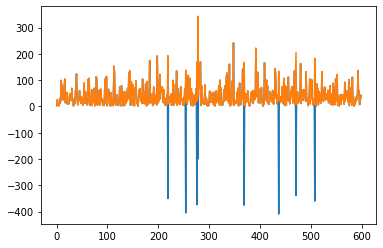

In [23]:
evaluate(model, env, 600)